<a href="https://colab.research.google.com/github/pritesh2292/Netflix-Movies-Tv-Shows-Clustering/blob/main/Netflix_unsupervised_ML_capstone_project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Liabraries

In [67]:
import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sns #importing our visualization library
import matplotlib.pyplot as plt
import missingno as msno
import matplotlib.cm as cm
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
import scipy.cluster.hierarchy as sch

import warnings
warnings.filterwarnings('ignore')

#Dataset Loading

In [2]:
# Load Dataset
# mount the drive on colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Reading Data

In [4]:
# read the data
path = "/content/drive/MyDrive/NETFLIX MOVIES AND TV SHOWS CLUSTERING.csv"
df = pd.read_csv(path)

#Dataset first look

In [5]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


#checking for null values

In [6]:
 df.isnull().sum()

show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64

#Heatmap 

<Axes: >

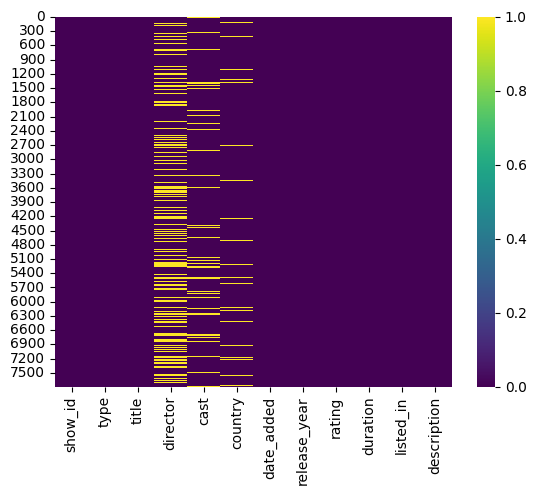

In [7]:
sns.heatmap(df.isnull(),cmap = 'viridis')

We have null values in director, cast,country,date_added and rating.So lets deal with it.

In [8]:
df['rating'].value_counts().unique()

array([2863, 1931,  806,  665,  386,  280,  271,  247,  194,   84,   39,
          6,    5,    3])

In the above data, we can choose to drop the director and cast columns completely as they are not a huge part for us while we visualize the data and they dont add any significant value to our analysis. We are only focused on visualizing this data hence dropping two columns wont be any trouble for us.But this should not be a regular practise as if we are making a recommender system, we cannot drop the director and cast of a movie as these are a key feature used to recommend movies to users



In [9]:
df.drop(['director','cast'],axis = 1,inplace = True)

In [10]:
df.head()

,show_id,type,title,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


We replaced all the Nan values in the country column with United States as Netflix was created in the USA and every show is aired on Netflix US. So instead of dropping the whole column we just replaced the values in it in order to save our data.

In [11]:
df['country'].replace(np.nan, 'United States',inplace  = True)

We already have released year for each movie and hence even if we dont have released date,it wont affect our analsis much. Hence we can Drop released date column.

In [12]:
df.drop(['date_added'],axis =1,inplace = True)

In [13]:
df.head()

,show_id,type,title,country,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,Brazil,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Mexico,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Singapore,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,United States,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,United States,2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [14]:
df['rating'].value_counts()

TV-MA       2863
TV-14       1931
TV-PG        806
R            665
PG-13        386
TV-Y         280
TV-Y7        271
PG           247
TV-G         194
NR            84
G             39
TV-Y7-FV       6
UR             5
NC-17          3
Name: rating, dtype: int64

In [15]:
df['listed_in'].value_counts()

Documentaries                                                                      334
Stand-Up Comedy                                                                    321
Dramas, International Movies                                                       320
Comedies, Dramas, International Movies                                             243
Dramas, Independent Movies, International Movies                                   215
                                                                                  ... 
Crime TV Shows, Romantic TV Shows, Spanish-Language TV Shows                         1
Crime TV Shows, International TV Shows, Reality TV                                   1
International Movies, Romantic Movies, Sci-Fi & Fantasy                              1
Stand-Up Comedy & Talk Shows, TV Mysteries, TV Sci-Fi & Fantasy                      1
International TV Shows, Spanish-Language TV Shows, Stand-Up Comedy & Talk Shows      1
Name: listed_in, Length: 492, dtype: int64

As we can see we only have 10 missing values in our rating column, we can either drop them or replace them. We have TV-MA which is the most common raing and hence we can replace all these nan values with TV-MA.

In [18]:
df['rating'].replace(np.nan, 'TV-MA',inplace  = True)

In [19]:
df.isnull().sum()

show_id         0
type            0
title           0
country         0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

We have now dealt with all of our missing data so lets get started with our data visualization

In [20]:
df.head()

,show_id,type,title,country,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,Brazil,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Mexico,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Singapore,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,United States,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,United States,2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


#Data Visualization

<Axes: xlabel='type', ylabel='count'>

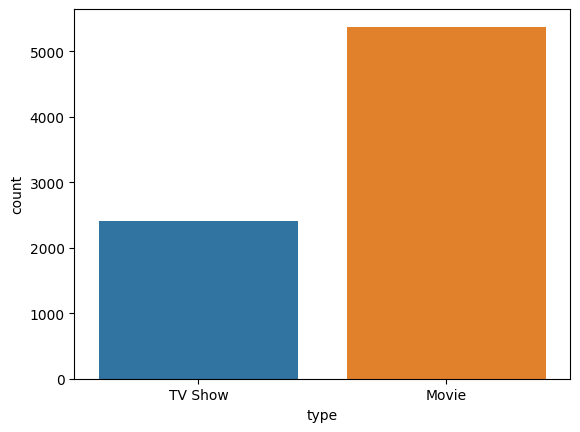

In [21]:
sns.countplot(x='type',data = df) #looking at number of Movies and TV shows

<Axes: xlabel='rating', ylabel='count'>

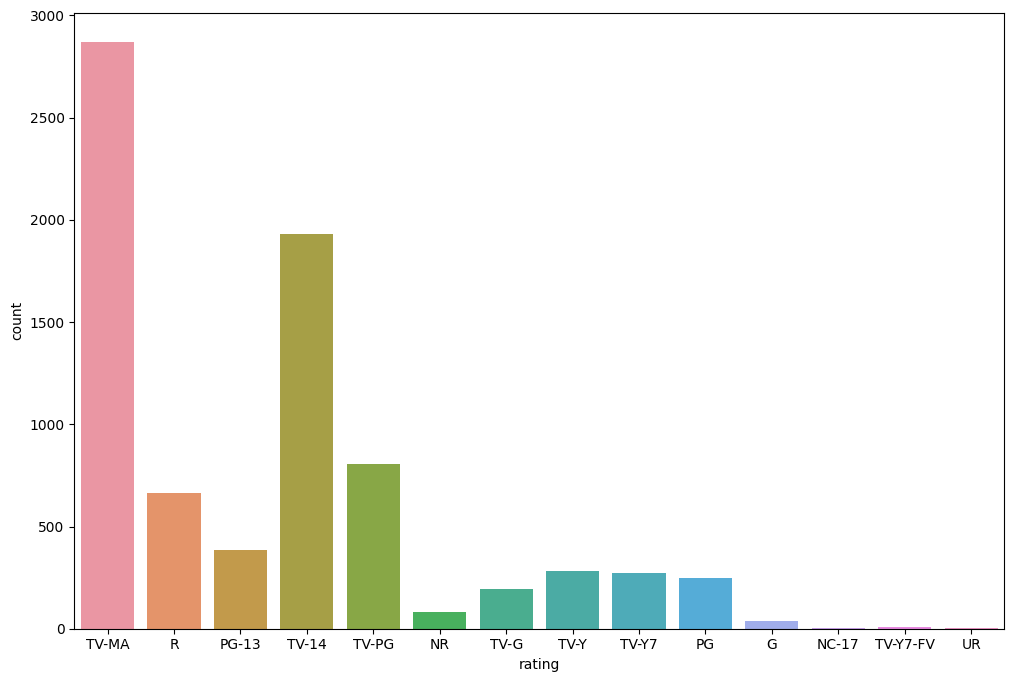

In [22]:
plt.figure(figsize = (12,8))
sns.countplot(x='rating',data = df)

<Axes: xlabel='release_year', ylabel='count'>

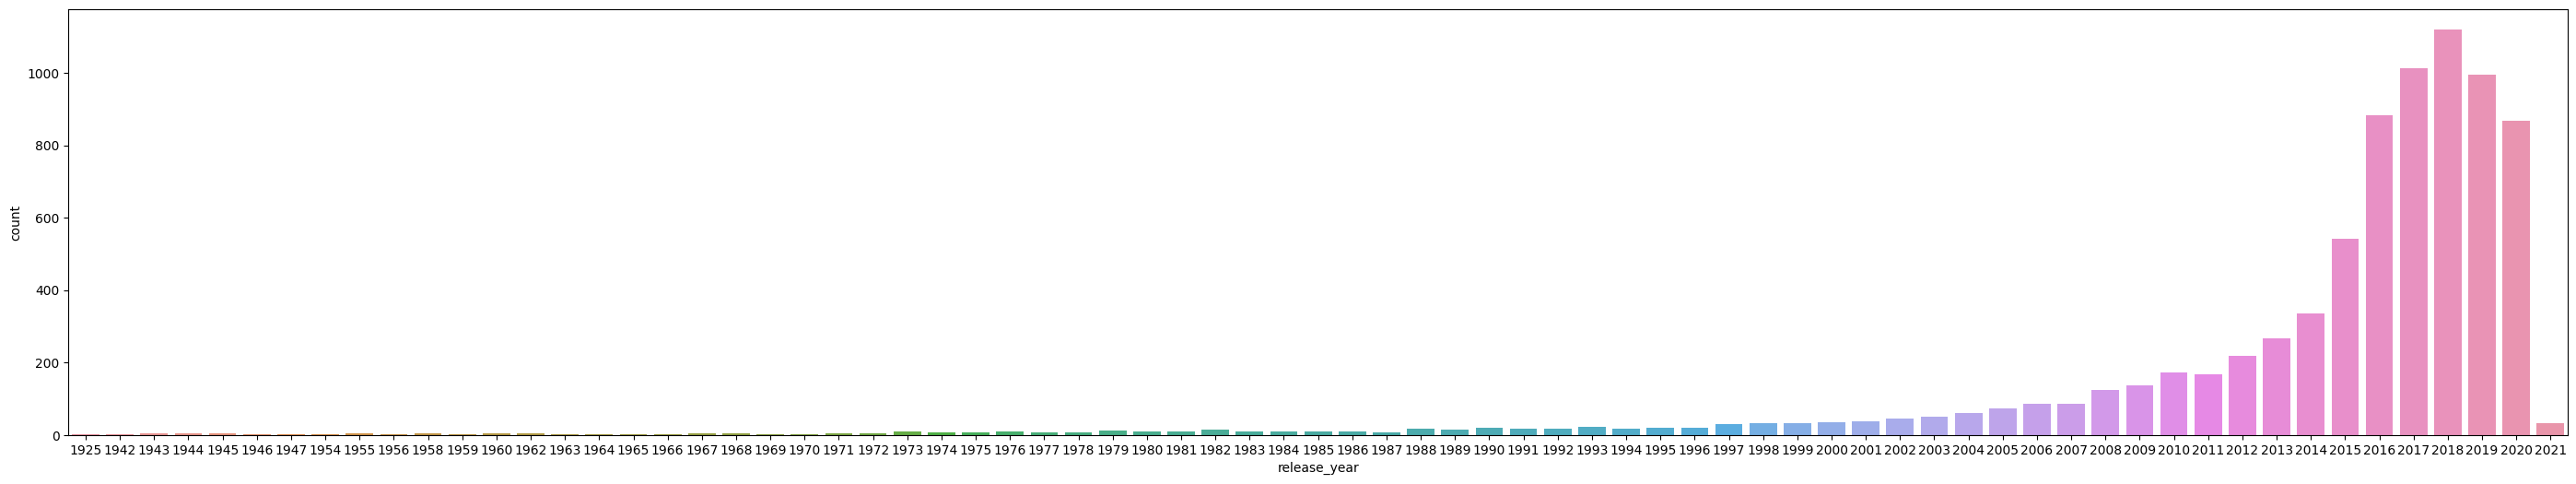

In [23]:
plt.figure(figsize = (35,6))
sns.countplot(x='release_year',data = df)

As we can see most of the Movies and Tv shows on Netflix are Released in the past decade and very few were released earlier

<Axes: xlabel='rating', ylabel='type'>

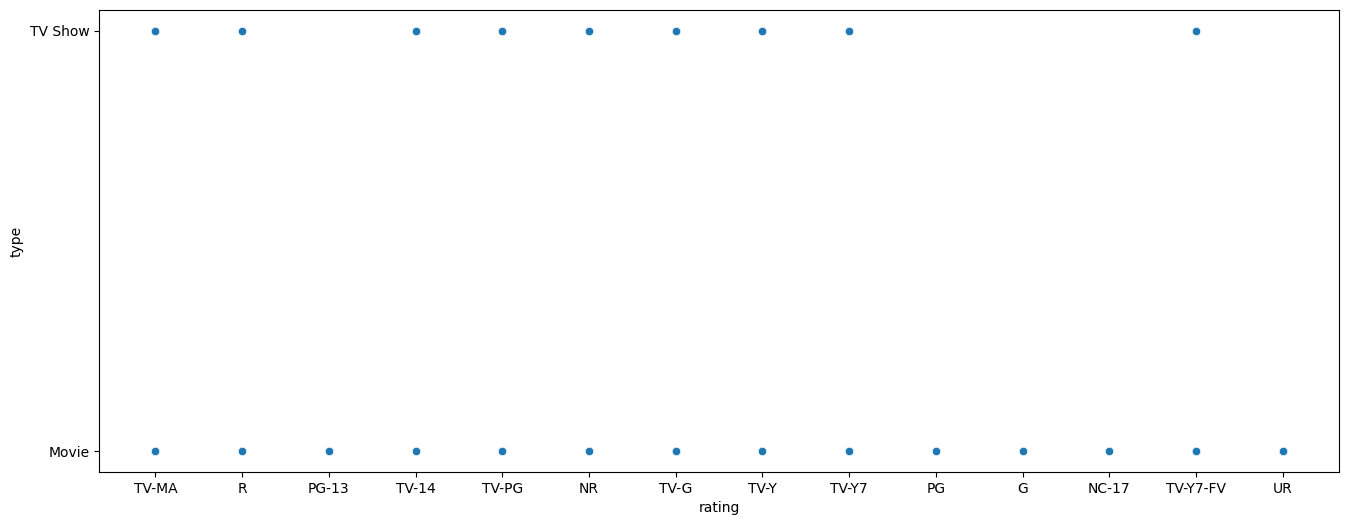

In [24]:
plt.figure(figsize=(16,6))
sns.scatterplot(x='rating',y='type',data = df) #analysing the type, whether its a movie or a movie v/s the rating it has

<Axes: xlabel='rating', ylabel='count'>

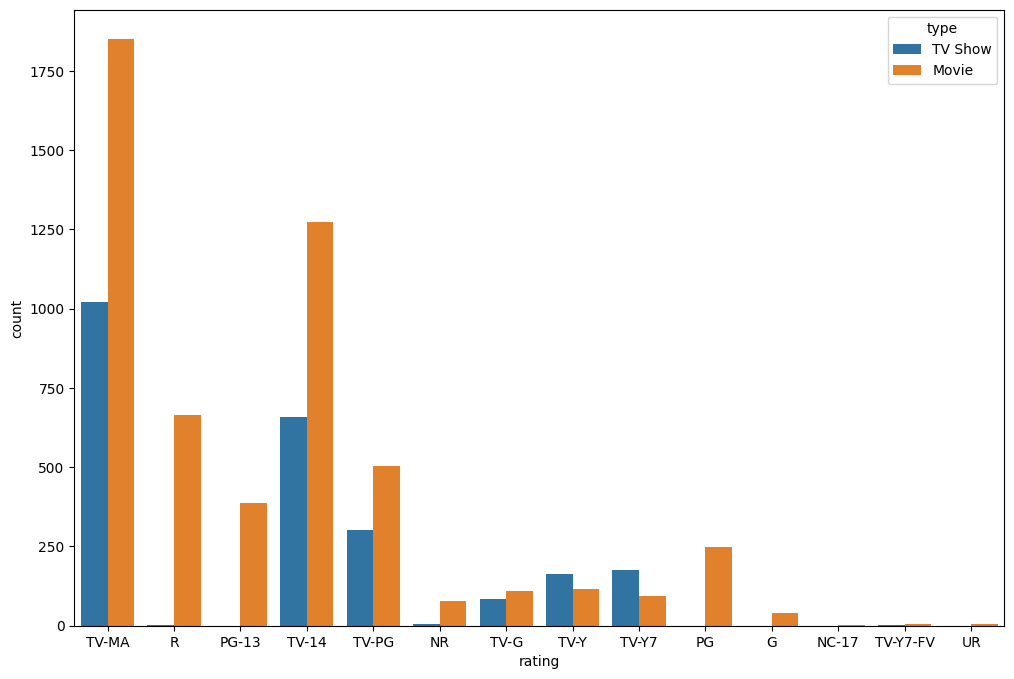

In [25]:
plt.figure(figsize = (12,8))
sns.countplot(x='rating',data = df,hue='type')

#Pie-chart for the Type: Movie and TV Shows

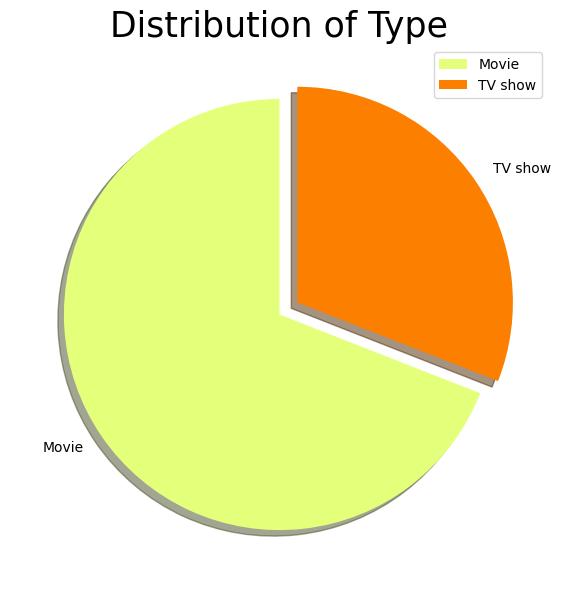

In [56]:
labels = ['Movie', 'TV show']
size = df['type'].value_counts()
colors = plt.cm.Wistia(np.linspace(0, 1, 2))
explode = [0, 0.1]
plt.rcParams['figure.figsize'] = (7, 7)
plt.pie(size,labels=labels, colors = colors, explode = explode, shadow = True, startangle = 90)
plt.title('Distribution of Type', fontsize = 25)
plt.legend()
plt.show()

In [27]:
import plotly.express as px #distribution according to countries
top_rated=df[0:10]
fig =px.sunburst(top_rated,path=['country'])
fig.show()

# pie-chart for rating

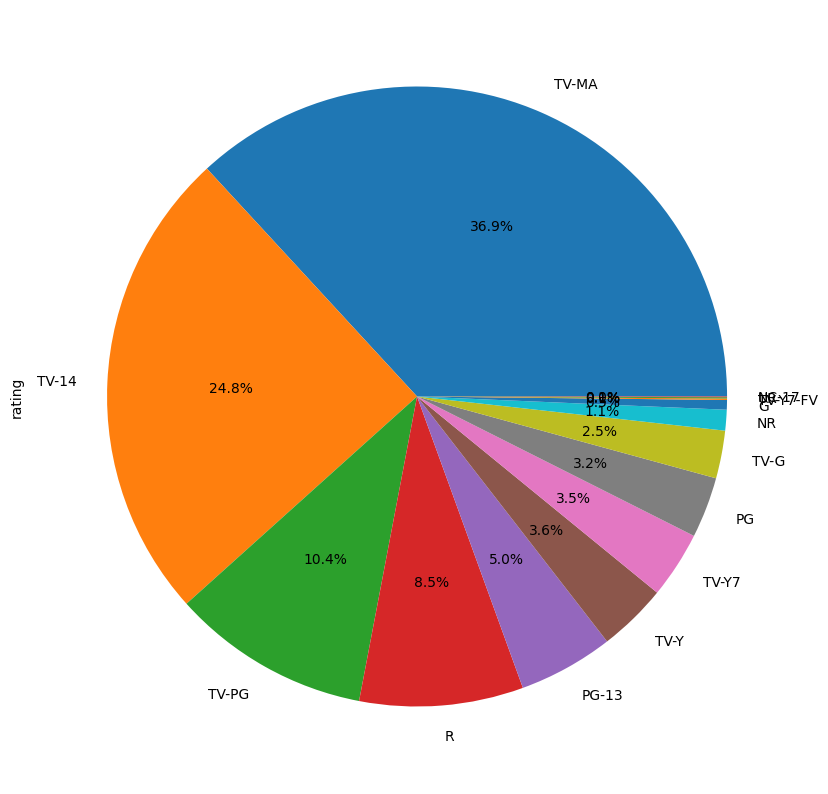

In [32]:
df['rating'].value_counts().plot.pie(autopct='%1.1f%%',figsize=(10,20)) #distribution according to the rating
plt.show()

In [33]:
old = df.sort_values("release_year", ascending = True) #oldest movies available on netflix
old = old[old['duration'] != ""]
old[['title', "release_year"]][:15]

,title,release_year
4867,Pioneers: First Women Filmmakers*,1925
6117,The Battle of Midway,1942
4960,Prelude to War,1942
7679,WWII: Report from the Aleutians,1943
7342,Undercover: How to Operate Behind Enemy Lines,1943
7616,Why We Fight: The Battle of Russia,1943
7268,Tunisian Victory,1944
6699,The Negro Soldier,1944
6657,The Memphis Belle: A Story of a\nFlying Fortress,1944
5371,San Pietro,1945


In [34]:
tag = "Stand-Up Comedy" #standup shows on Netflix
df["relevant"] = df['listed_in'].fillna("").apply(lambda x : 1 if tag.lower() in x.lower() else 0)
com = df[df["relevant"] == 1]
com[com["country"] == "United States"][["title", "country","release_year"]].head(10)

,title,country,release_year
197,A Little Help with Carol Burnett,United States,2018
305,Adam Devine: Best Time of Our Lives,United States,2019
307,ADAM SANDLER 100% FRESH,United States,2018
310,Adel Karam: Live from Beirut,United States,2018
386,Ali Wong: Baby Cobra,United States,2016
387,Ali Wong: Hard Knock Wife,United States,2018
482,Amy Schumer Growing,United States,2019
483,Amy Schumer: The Leather Special,United States,2017
535,Anjelah Johnson: Not Fancy,United States,2015
550,Anthony Jeselnik: Fire in the Maternity Ward,United States,2019


In [35]:
tag = "Kids' TV" #Kids TV shows on Netflix
df["relevant"] = df['listed_in'].fillna("").apply(lambda x : 1 if tag.lower() in x.lower() else 0)
com = df[df["relevant"] == 1]
com[com["country"] == "United States"][["title", "country","release_year"]].head(10)

,title,country,release_year
108,3Below: Tales of Arcadia,United States,2019
225,A Series of Unfortunate Events,United States,2019
380,Alexa & Katie,United States,2020
396,Alien TV,United States,2020
411,All Hail King Julien,United States,2017
412,All Hail King Julien: Exiled,United States,2017
570,Archibald's Next Big Thing,United States,2020
598,Ask the StoryBots,United States,2019
632,Avatar: The Last Airbender,United States,2007
704,Bakugan: Armored Alliance,United States,2020


In [36]:
df_countries = pd.DataFrame(df.country.value_counts().reset_index().values, columns=["country", "count"])
df_countries.head()

,country,count
0,United States,3062
1,India,923
2,United Kingdom,397
3,Japan,226
4,South Korea,183


#distribution of content on basis of countries

In [41]:
fig = px.choropleth(locationmode='country names',locations=df_countries.country,labels=df_countries["count"])
fig.show()

In [42]:
date = pd.DataFrame(df.release_year.value_counts().reset_index().values, columns=["Year", "Count"])
date.head()

,Year,Count
0,2018,1121
1,2017,1012
2,2019,996
3,2016,882
4,2020,868


Text(0.5, 1.0, 'Frequency of Movies which were released in different years and are available on Netflix')

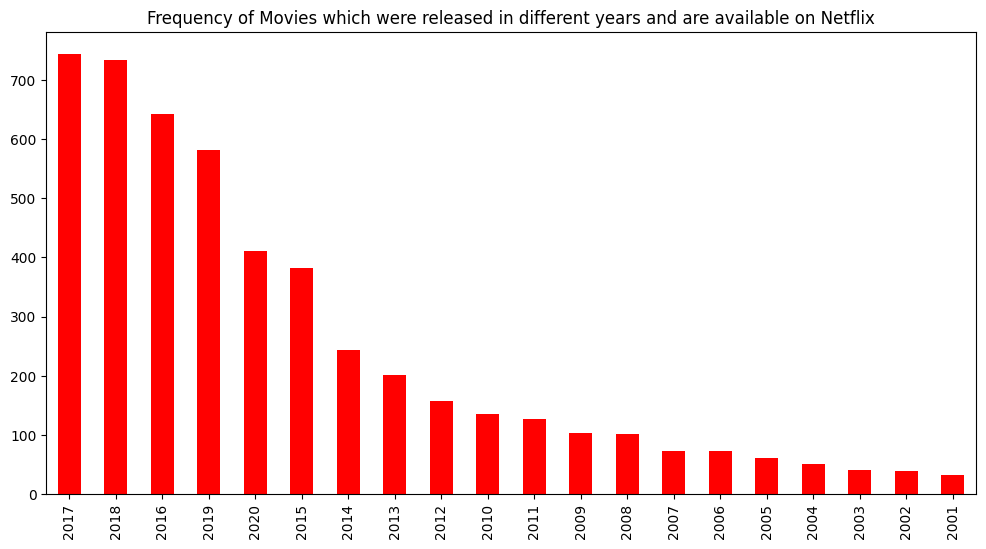

In [43]:
plt.figure(figsize=(12,6))
df[df["type"]=="Movie"]["release_year"].value_counts()[:20].plot(kind="bar",color="Red")
plt.title("Frequency of Movies which were released in different years and are available on Netflix")

Text(0.5, 1.0, 'Frequency of TV shows which were released in different years and are available on Netflix')

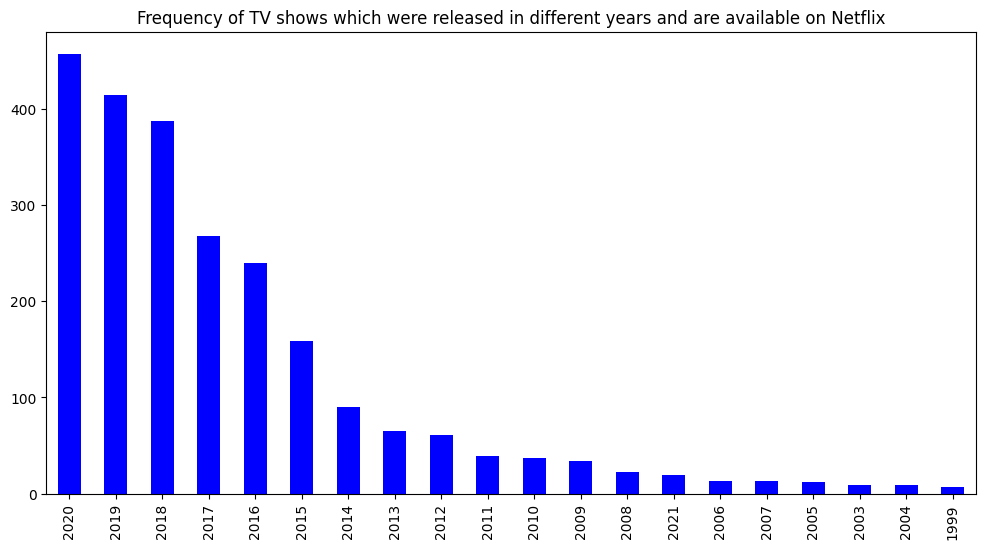

In [44]:
plt.figure(figsize=(12,6))
df[df["type"]=="TV Show"]["release_year"].value_counts()[:20].plot(kind="bar",color="Blue")
plt.title("Frequency of TV shows which were released in different years and are available on Netflix")

Text(0.5, 1.0, 'Top 10 Genres of Movies')

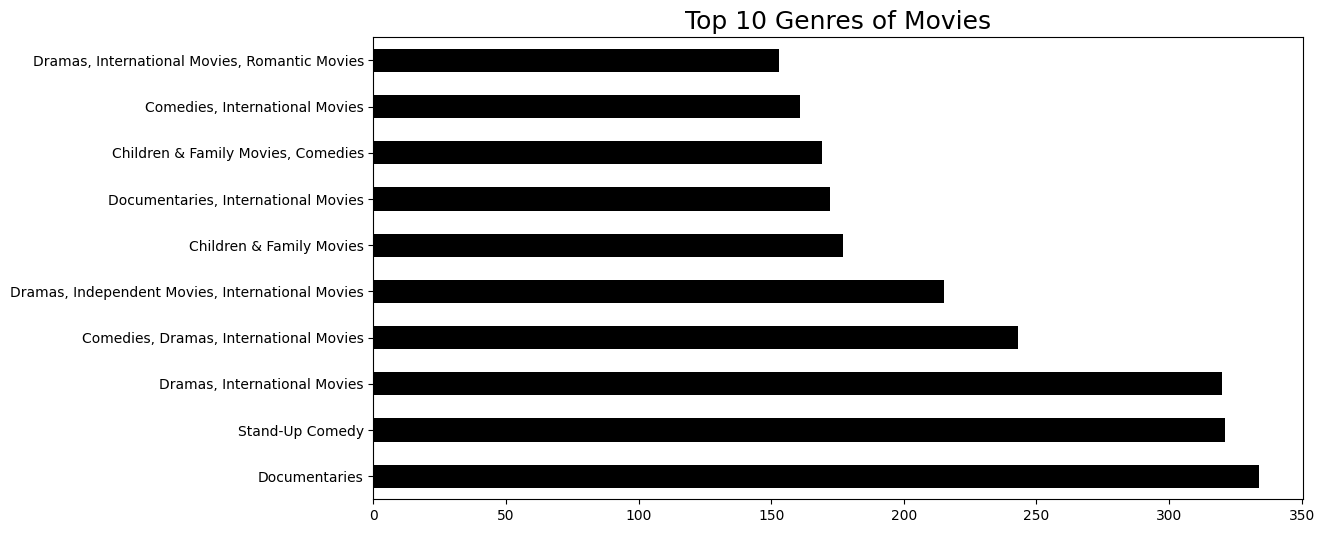

In [45]:
plt.figure(figsize=(12,6))
df[df["type"]=="Movie"]["listed_in"].value_counts()[:10].plot(kind="barh",color="black")
plt.title("Top 10 Genres of Movies",size=18)

Text(0.5, 1.0, 'Top 10 Genres of TV Shows')

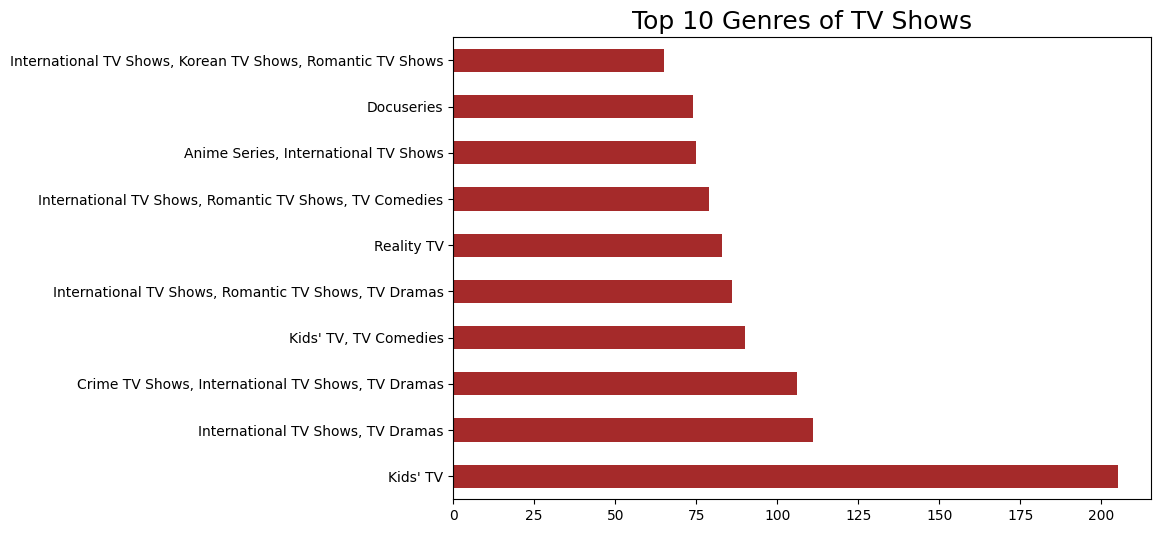

In [49]:
plt.figure(figsize=(9,6))
df[df["type"]=="TV Show"]["listed_in"].value_counts()[:10].plot(kind="barh",color="brown")
plt.title("Top 10 Genres of TV Shows",size=18)

#WordCloud

In [50]:
from wordcloud import WordCloud

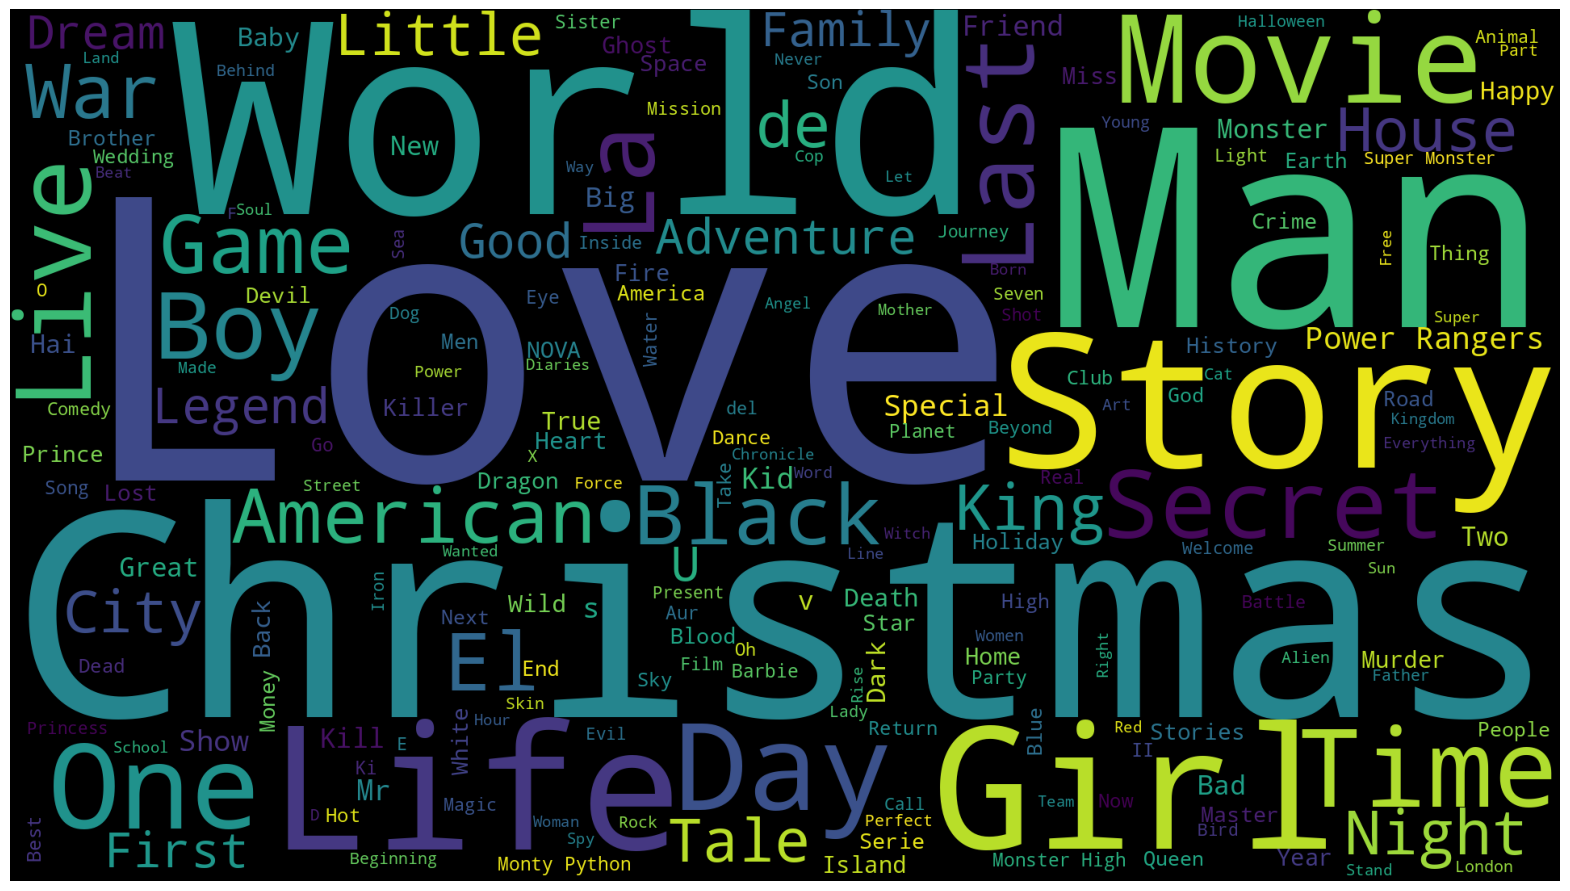

In [53]:
plt.subplots(figsize=(20,12))
wordcloud = WordCloud(background_color='Black',width=1920,height=1080).generate(" ".join(df.title))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('cast.png')
plt.show()

#Country

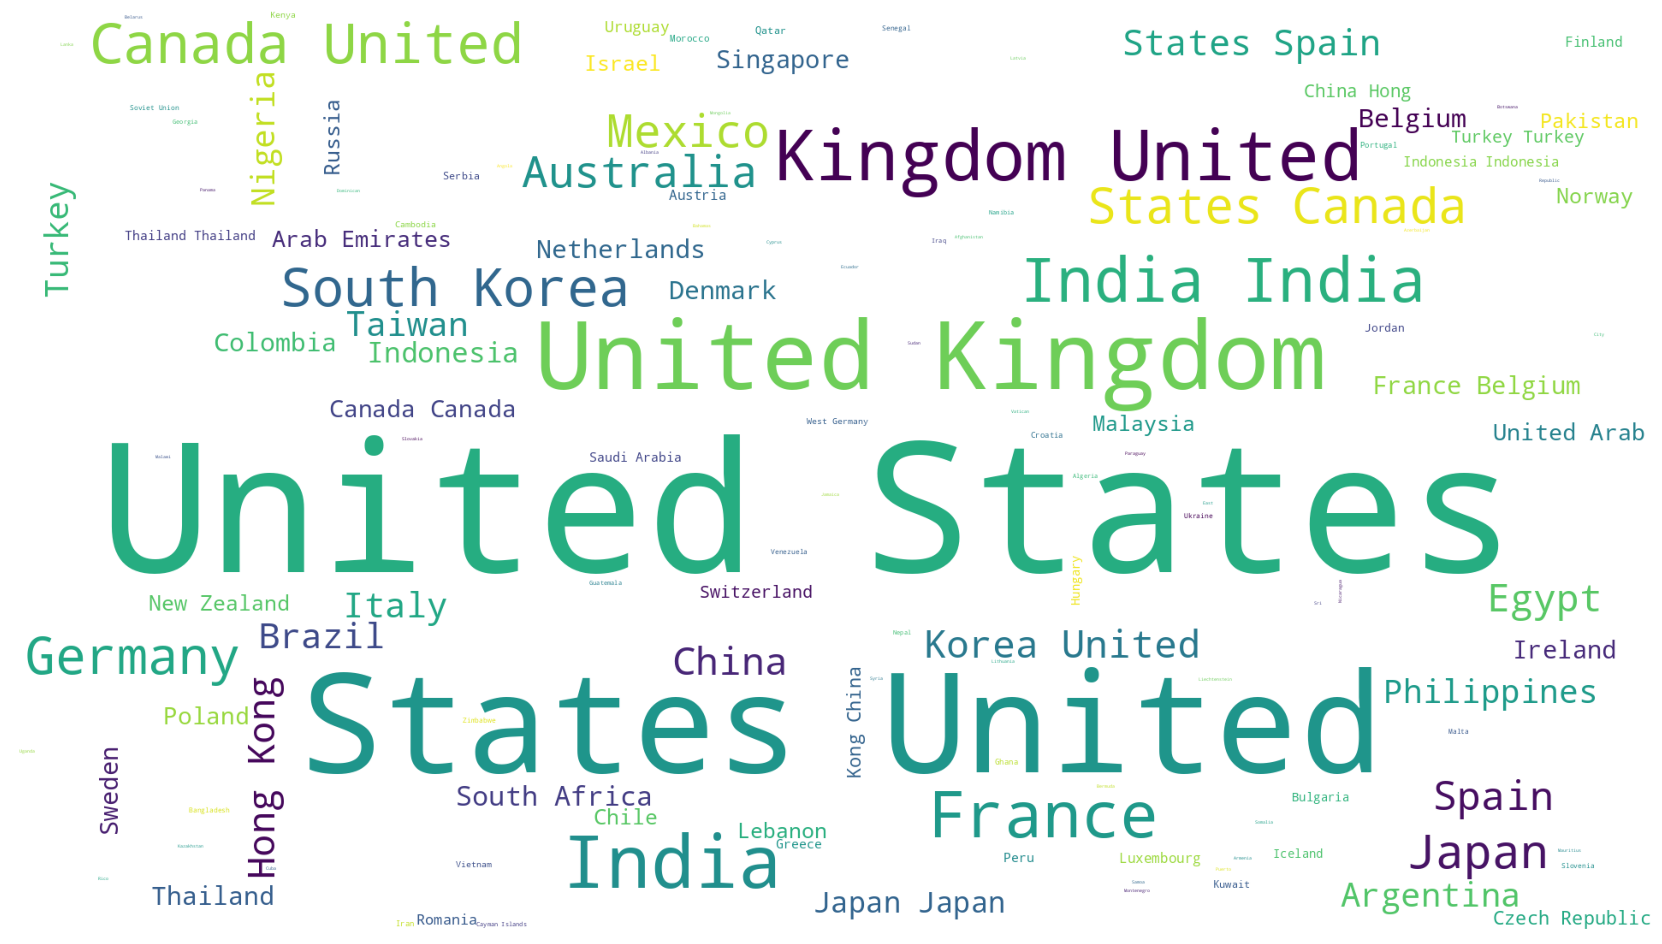

In [58]:
plt.subplots(figsize=(22,12))
wordcloud = WordCloud(background_color='white',width=1920,height=1080).generate(" ".join(df.country))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('country.png')
plt.show()

#Data Prepreation (nlp data)

description

In [68]:
df.columns

Index(['show_id', 'type', 'title', 'country', 'release_year', 'rating',
       'duration', 'listed_in', 'description', 'relevant'],
      dtype='object')

In [69]:
df.description.iloc[0]

'In a future where the elite inhabit an island paradise far from the crowded slums, you get one chance to join the 3% saved from squalor.'

In [70]:
First_des = df.description.iloc[0]
First_des

'In a future where the elite inhabit an island paradise far from the crowded slums, you get one chance to join the 3% saved from squalor.'

 Importing necessary libraries

In [71]:
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

Downloading nltk

In [72]:
import nltk 
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> 1


    Error loading 1: Package '1' not found in index



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> l
Packages:
  [ ] abc................. Australian Broadcasting Commission 2006
  [ ] alpino.............. Alpino Dutch Treebank
  [ ] averaged_perceptron_tagger Averaged Perceptron Tagger
  [ ] averaged_perceptron_tagger_ru Averaged Perceptron Tagger (Russian)
  [ ] basque_grammars..... Grammars for Basque
  [ ] bcp47............... BCP-47 Language Tags
  [ ] biocreative_ppi..... BioCreAtIvE (Critical Assessment of Information
                           Extraction Systems in Biology)
  [ ] bllip_wsj_no_aux.... BLLIP Parser: WSJ Model
  [ ] book_grammars....... Grammars from NLTK Book
  [ ] brown............... Brown Corpus
  [ ] brown_tei........... Brown Corpus (TEI XML Version)
  [ ] cess_cat.

True

Removing punctuations

In [73]:
def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string
    # replacing the punctuations with no space, 
    # which in effect deletes the punctuation marks 
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)

In [74]:
df['description'] = df['description'].apply(remove_punctuation)
df.head()

,show_id,type,title,country,release_year,rating,duration,listed_in,description,relevant
0,s1,TV Show,3%,Brazil,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,0
1,s2,Movie,7:19,Mexico,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,0
2,s3,Movie,23:59,Singapore,2011,R,78 min,"Horror Movies, International Movies",When an army recruit is found dead his fellow ...,0
3,s4,Movie,9,United States,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...",In a postapocalyptic world ragdoll robots hide...,0
4,s5,Movie,21,United States,2008,PG-13,123 min,Dramas,A brilliant group of students become cardcount...,0


 Removing stopwords

In [75]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

extracting the stopwords from nltk library

In [76]:
sw = nltk.corpus.stopwords.words('english')
# displaying the stopwords
for i in sw:
  print(i , end=',  ')

i,  me,  my,  myself,  we,  our,  ours,  ourselves,  you,  you're,  you've,  you'll,  you'd,  your,  yours,  yourself,  yourselves,  he,  him,  his,  himself,  she,  she's,  her,  hers,  herself,  it,  it's,  its,  itself,  they,  them,  their,  theirs,  themselves,  what,  which,  who,  whom,  this,  that,  that'll,  these,  those,  am,  is,  are,  was,  were,  be,  been,  being,  have,  has,  had,  having,  do,  does,  did,  doing,  a,  an,  the,  and,  but,  if,  or,  because,  as,  until,  while,  of,  at,  by,  for,  with,  about,  against,  between,  into,  through,  during,  before,  after,  above,  below,  to,  from,  up,  down,  in,  out,  on,  off,  over,  under,  again,  further,  then,  once,  here,  there,  when,  where,  why,  how,  all,  any,  both,  each,  few,  more,  most,  other,  some,  such,  no,  nor,  not,  only,  own,  same,  so,  than,  too,  very,  s,  t,  can,  will,  just,  don,  don't,  should,  should've,  now,  d,  ll,  m,  o,  re,  ve,  y,  ain,  aren,  

In [77]:
print("Number of stopwords in english : ", len(sw))

Number of stopwords in english :  179


In [78]:
def remove_stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    #Method 1
    text1 = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text1)

In [79]:
df['description'] = df['description'].apply( remove_stopwords )
df.head()

,show_id,type,title,country,release_year,rating,duration,listed_in,description,relevant
0,s1,TV Show,3%,Brazil,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",future elite inhabit island paradise far crowd...,0
1,s2,Movie,7:19,Mexico,2016,TV-MA,93 min,"Dramas, International Movies",devastating earthquake hits mexico city trappe...,0
2,s3,Movie,23:59,Singapore,2011,R,78 min,"Horror Movies, International Movies",army recruit found dead fellow soldiers forced...,0
3,s4,Movie,9,United States,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...",postapocalyptic world ragdoll robots hide fear...,0
4,s5,Movie,21,United States,2008,PG-13,123 min,Dramas,brilliant group students become cardcounting e...,0


#Using CountVectorizer() to count vocabulary items

In [80]:
# Create a count vectorizer object
count_vectorizer = CountVectorizer()
# fit the count vectorizer using the text data
count_vectorizer.fit(df['description'])
# Collect the vocabulary items used in the vectorizer
dictionary = count_vectorizer.vocabulary_.items()

In [81]:
dictionary

dict_items([('future', 7161), ('elite', 5647), ('inhabit', 8953), ('island', 9229), ('paradise', 12681), ('far', 6403), ('crowded', 4233), ('slums', 16100), ('get', 7357), ('one', 12309), ('chance', 3060), ('join', 9447), ('saved', 15203), ('squalor', 16516), ('devastating', 4829), ('earthquake', 5496), ('hits', 8314), ('mexico', 11109), ('city', 3326), ('trapped', 17918), ('survivors', 17064), ('walks', 18876), ('life', 10176), ('wait', 18853), ('rescued', 14520), ('trying', 18060), ('desperately', 4782), ('stay', 16625), ('alive', 781), ('army', 1222), ('recruit', 14240), ('found', 6944), ('dead', 4496), ('fellow', 6531), ('soldiers', 16225), ('forced', 6880), ('confront', 3782), ('terrifying', 17440), ('secret', 15392), ('thats', 17494), ('haunting', 8018), ('jungle', 9542), ('training', 17875), ('camp', 2751), ('postapocalyptic', 13360), ('world', 19313), ('ragdoll', 13959), ('robots', 14846), ('hide', 8193), ('fear', 6482), ('dangerous', 4423), ('machines', 10536), ('exterminate',

In [82]:
vocab = [ ]
count_of_vocab = []
for key , value in dictionary:
  vocab.append( key )
  count_of_vocab.append( value )

Creating a new DataFrame vocab_before_stemming

In [84]:
# Store the count in panadas dataframe with vocab as index
vocab_before_stemming = pd.DataFrame({"Word": vocab ,
                                      "count" :count_of_vocab})
# Sort the dataframe
vocab_before_stemming = vocab_before_stemming.sort_values("count" ,ascending=False)
     

In [85]:
vocab_before_stemming.head(4)

,Word,count
18869,şeref,19607
10401,ōarai,19606
12385,łukasz,19605
11110,überelite,19604


In [86]:
vocab_before_stemming.head(20).T

,18869,10401,12385,11110,11681,13302,6591,18207,10439,9872,19569,6543,19604,16427,7198,18409,19594,19601,10304,18084
Word,şeref,ōarai,łukasz,überelite,über,ömer,émile,ángel,álvaro,álex,zé,zurich,zumbo,zulu,zuhu,zuckerberg,zoé,zozo,zoya,zorro
count,19607,19606,19605,19604,19603,19602,19601,19600,19599,19598,19597,19596,19595,19594,19593,19592,19591,19590,19589,19588


In [87]:
vocab_before_stemming.tail(4)

,Word,count
639,100,3
7622,10,2
7968,009,1
6873,007,0


TOP 10 most occurred words

In [88]:
top15_most_ocurred_vacab = vocab_before_stemming.head(15)

In [89]:
top15_most_occurred_words = top15_most_ocurred_vacab.Word.values 
top15_most_occurred_words
     

array(['şeref', 'ōarai', 'łukasz', 'überelite', 'über', 'ömer', 'émile',
       'ángel', 'álvaro', 'álex', 'zé', 'zurich', 'zumbo', 'zulu', 'zuhu'],
      dtype=object)

In [90]:
top15_most_occurred_words_count = top15_most_ocurred_vacab['count'].values 
top15_most_occurred_words_count

array([19607, 19606, 19605, 19604, 19603, 19602, 19601, 19600, 19599,
       19598, 19597, 19596, 19595, 19594, 19593])

<BarContainer object of 15 artists>

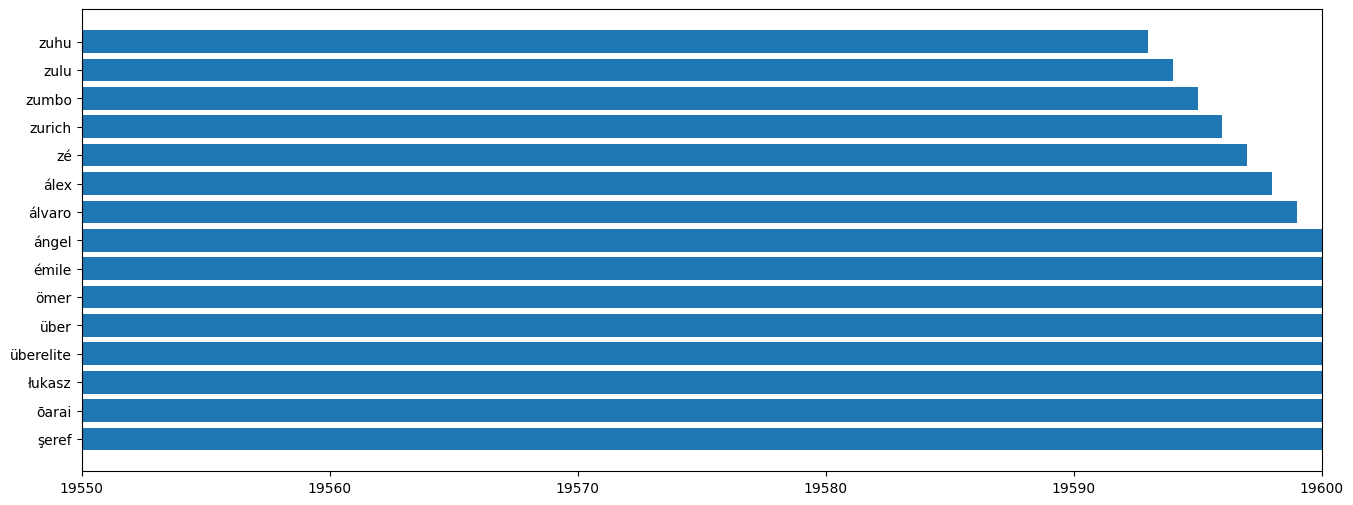

In [91]:
plt.figure( figsize = ( 16,6 ))
plt.xlim(19550, 19600)
plt.barh(top15_most_occurred_words , top15_most_occurred_words_count )

Now will use SnowballStemmer( 'english' )

In [92]:
# Create an object of stemming function
stemmer = SnowballStemmer("english")
     

In [93]:
def Apply_stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 

In [94]:
#Stemming for description
df['description'] = df['description'].apply( Apply_stemming )
df.head()
     

,show_id,type,title,country,release_year,rating,duration,listed_in,description,relevant
0,s1,TV Show,3%,Brazil,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",futur elit inhabit island paradis far crowd sl...,0
1,s2,Movie,7:19,Mexico,2016,TV-MA,93 min,"Dramas, International Movies",devast earthquak hit mexico citi trap survivor...,0
2,s3,Movie,23:59,Singapore,2011,R,78 min,"Horror Movies, International Movies",armi recruit found dead fellow soldier forc co...,0
3,s4,Movie,9,United States,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...",postapocalypt world ragdol robot hide fear dan...,0
4,s5,Movie,21,United States,2008,PG-13,123 min,Dramas,brilliant group student becom cardcount expert...,0


 Now again will use TfidfVectorizer (after stemming)

In [95]:
# Create the object of tfid vectorizer
tfid_vectorizer = TfidfVectorizer()

# Fit the vectorizer using the text data
tfid_vectorizer.fit(df['description'])

# Collect the vocabulary items used in the vectorizer
dictionary = tfid_vectorizer.vocabulary_.items()

In [96]:
# Lists to store the vocab and counts
vocab = []
count_of_vocab = []
# Iterate through each vocab and count append the value to designated lists
for key, value in dictionary:
    vocab.append(key)
    count_of_vocab.append(value)

Creating a new DataFrame vocab_after_stemming

In [97]:
# Store the count in panadas dataframe with vocab as index
vocab_after_stemming = pd.DataFrame({"Word": vocab ,
                                      "count" :count_of_vocab})
# Sort the dataframe
vocab_after_stemming = vocab_after_stemming.sort_values("count" ,ascending=False)

In [98]:
top15_most_ocurred_vocab = vocab_after_stemming.head(15)
     


In [99]:
top15_most_occurred_words = top15_most_ocurred_vocab.Word.values 
top15_most_occurred_words

array(['şeref', 'ōarai', 'łukasz', 'überelit', 'über', 'ömer', 'émile',
       'ángel', 'álvaro', 'álex', 'zé', 'zurich', 'zumbo', 'zulu', 'zuhu'],
      dtype=object)

In [100]:
top15_most_occurred_words_count = top15_most_ocurred_vocab['count'].values 
top15_most_occurred_words_count

array([14252, 14251, 14250, 14249, 14248, 14247, 14246, 14245, 14244,
       14243, 14242, 14241, 14240, 14239, 14238])

<BarContainer object of 15 artists>

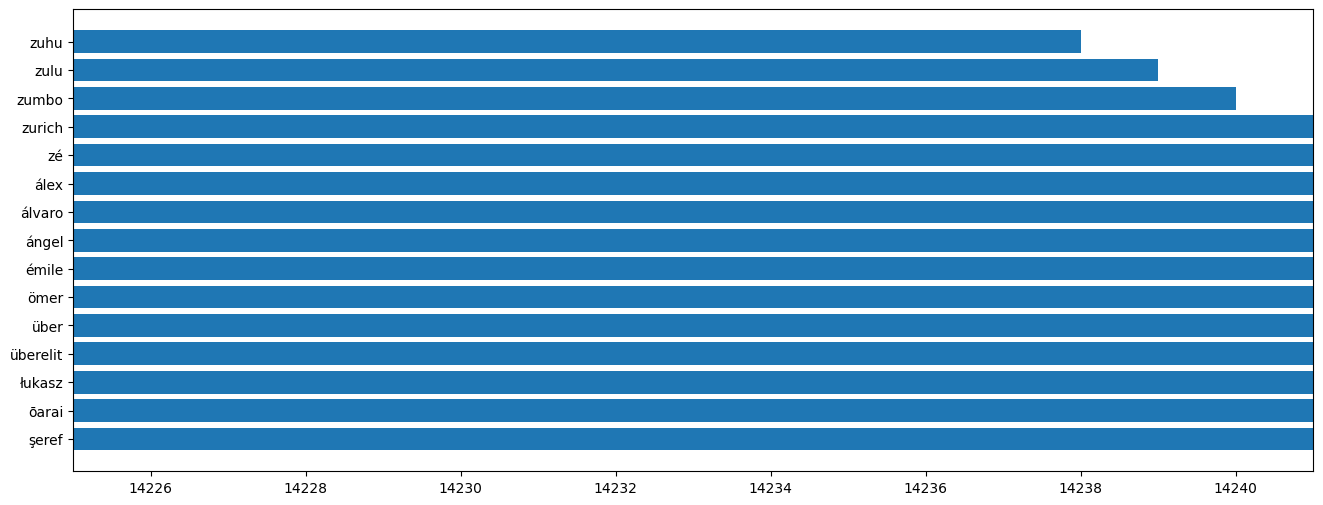

In [102]:
plt.figure( figsize = ( 16,6 ))
plt.xlim(14225, 14241)
plt.barh(top15_most_occurred_words , top15_most_occurred_words_count )

Adding a new column length which will contain length of description

In [103]:
df['Length(description)'] = df['description'].apply(lambda x: len(x))
     

In [104]:
df.head(3)
     

,show_id,type,title,country,release_year,rating,duration,listed_in,description,relevant,Length(description)
0,s1,TV Show,3%,Brazil,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",futur elit inhabit island paradis far crowd sl...,0,82
1,s2,Movie,7:19,Mexico,2016,TV-MA,93 min,"Dramas, International Movies",devast earthquak hit mexico citi trap survivor...,0,88
2,s3,Movie,23:59,Singapore,2011,R,78 min,"Horror Movies, International Movies",armi recruit found dead fellow soldier forc co...,0,102


In [105]:
df.description.iloc[0]

'futur elit inhabit island paradis far crowd slum get one chanc join 3 save squalor'

In [106]:
len(df.description.iloc[0])

82

# listed_in

Removing punctutations

In [108]:
df.columns


Index(['show_id', 'type', 'title', 'country', 'release_year', 'rating',
       'duration', 'listed_in', 'description', 'relevant',
       'Length(description)'],
      dtype='object')

In [109]:
df['listed_in'] = df['listed_in'].apply(remove_punctuation)
df.head()

,show_id,type,title,country,release_year,rating,duration,listed_in,description,relevant,Length(description)
0,s1,TV Show,3%,Brazil,2020,TV-MA,4 Seasons,International TV Shows TV Dramas TV SciFi Fan...,futur elit inhabit island paradis far crowd sl...,0,82
1,s2,Movie,7:19,Mexico,2016,TV-MA,93 min,Dramas International Movies,devast earthquak hit mexico citi trap survivor...,0,88
2,s3,Movie,23:59,Singapore,2011,R,78 min,Horror Movies International Movies,armi recruit found dead fellow soldier forc co...,0,102
3,s4,Movie,9,United States,2009,PG-13,80 min,Action Adventure Independent Movies SciFi Fa...,postapocalypt world ragdol robot hide fear dan...,0,89
4,s5,Movie,21,United States,2008,PG-13,123 min,Dramas,brilliant group student becom cardcount expert...,0,99


Removing stopwords

In [110]:
#Remove stopwords for listed_in
df['listed_in'] = df['listed_in'].apply( remove_stopwords )
df.head( 2 )

,show_id,type,title,country,release_year,rating,duration,listed_in,description,relevant,Length(description)
0,s1,TV Show,3%,Brazil,2020,TV-MA,4 Seasons,international tv shows tv dramas tv scifi fantasy,futur elit inhabit island paradis far crowd sl...,0,82
1,s2,Movie,7:19,Mexico,2016,TV-MA,93 min,dramas international movies,devast earthquak hit mexico citi trap survivor...,0,88


Using CountVectorizer() to count vocabulary items

In [111]:
# Create a count vectorizer object
count_vectorizer = CountVectorizer()
# fit the count vectorizer using the text data
count_vectorizer.fit(df['listed_in'])
# Collect the vocabulary items used in the vectorizer
dictionary = count_vectorizer.vocabulary_.items()

In [112]:
dictionary

dict_items([('international', 19), ('tv', 41), ('shows', 33), ('dramas', 12), ('scifi', 31), ('fantasy', 15), ('movies', 23), ('horror', 17), ('action', 0), ('adventure', 1), ('independent', 18), ('mysteries', 26), ('thrillers', 40), ('crime', 8), ('docuseries', 11), ('documentaries', 10), ('sports', 36), ('comedies', 6), ('anime', 2), ('series', 32), ('reality', 28), ('romantic', 29), ('science', 30), ('nature', 27), ('british', 3), ('korean', 21), ('music', 24), ('musicals', 25), ('lgbtq', 22), ('faith', 13), ('spirituality', 35), ('kids', 20), ('spanishlanguage', 34), ('children', 4), ('family', 14), ('classic', 5), ('cult', 9), ('standup', 37), ('comedy', 7), ('talk', 38), ('teen', 39), ('features', 16)])

In [113]:
vocab = [ ]
count_of_vocab = []
for key , value in dictionary:
  vocab.append( key )
  count_of_vocab.append( value )

In [114]:
listed_in_vocab_before_stem = pd.DataFrame({"Word": vocab , "count" :count_of_vocab})

listed_in_vocab_before_stem = listed_in_vocab_before_stem.sort_values("count" ,ascending=False)

In [115]:
listed_in_vocab_before_stem.head()

,Word,count
1,tv,41
12,thrillers,40
40,teen,39
39,talk,38
37,standup,37


In [116]:
listed_in_vocab_before_stem.tail()

,Word,count
33,children,4
24,british,3
18,anime,2
9,adventure,1
8,action,0


TOP 10 most occurred words in listed in

In [117]:
top15_most_ocurred_vocab_listed_in = listed_in_vocab_before_stem.head(15)
     

In [118]:
top15_most_ocurred_words_listed_in = top15_most_ocurred_vocab_listed_in.Word.values 
top15_most_ocurred_words_listed_in
     

array(['tv', 'thrillers', 'teen', 'talk', 'standup', 'sports',
       'spirituality', 'spanishlanguage', 'shows', 'series', 'scifi',
       'science', 'romantic', 'reality', 'nature'], dtype=object)

In [119]:
top15_most_occurred_words_in_listed_in_count = top15_most_ocurred_vocab_listed_in['count'].values 
top15_most_occurred_words_in_listed_in_count

array([41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27])

<BarContainer object of 15 artists>

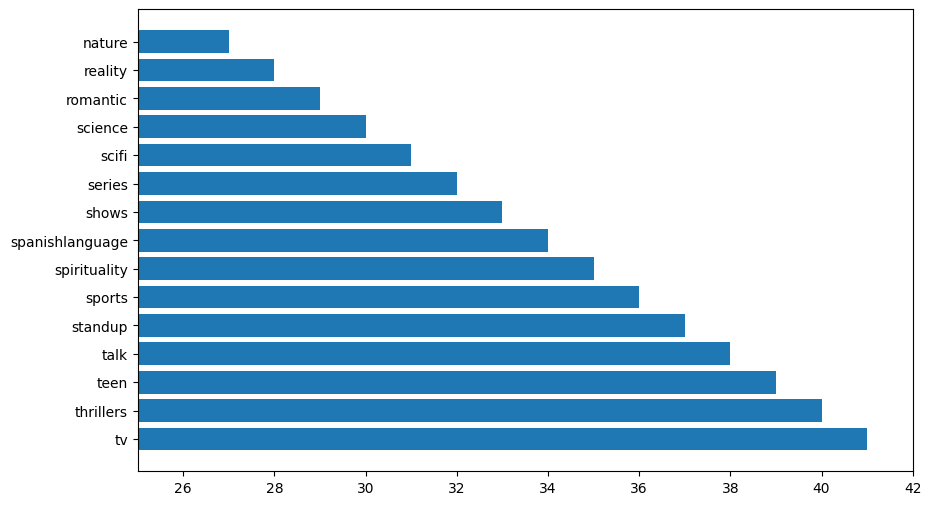

In [120]:
plt.figure( figsize = ( 10,6 ))
plt.xlim(25, 42 )
plt.barh(top15_most_ocurred_words_listed_in , top15_most_occurred_words_in_listed_in_count )

 Now will use SnowballStemmer( 'english' )

In [121]:
#Stemming for description
df['listed_in'] = df['listed_in'].apply( Apply_stemming )
df.head(3)

,show_id,type,title,country,release_year,rating,duration,listed_in,description,relevant,Length(description)
0,s1,TV Show,3%,Brazil,2020,TV-MA,4 Seasons,intern tv show tv drama tv scifi fantasi,futur elit inhabit island paradis far crowd sl...,0,82
1,s2,Movie,7:19,Mexico,2016,TV-MA,93 min,drama intern movi,devast earthquak hit mexico citi trap survivor...,0,88
2,s3,Movie,23:59,Singapore,2011,R,78 min,horror movi intern movi,armi recruit found dead fellow soldier forc co...,0,102


Now will use TfidfVectorizer (after stemming)

In [122]:
# Create the object of tfid vectorizer
tfid_vectorizer = TfidfVectorizer()

# Fit the vectorizer using the text data
tfid_vectorizer.fit(df['listed_in'])

# Collect the vocabulary items used in the vectorizer
dictionary = tfid_vectorizer.vocabulary_.items()
     

In [123]:
dictionary

dict_items([('intern', 18), ('tv', 39), ('show', 31), ('drama', 11), ('scifi', 29), ('fantasi', 14), ('movi', 22), ('horror', 16), ('action', 0), ('adventur', 1), ('independ', 17), ('mysteri', 24), ('thriller', 38), ('crime', 7), ('docuseri', 10), ('documentari', 9), ('sport', 34), ('comedi', 6), ('anim', 2), ('seri', 30), ('realiti', 26), ('romant', 27), ('scienc', 28), ('natur', 25), ('british', 3), ('korean', 20), ('music', 23), ('lgbtq', 21), ('faith', 12), ('spiritu', 33), ('kid', 19), ('spanishlanguag', 32), ('children', 4), ('famili', 13), ('classic', 5), ('cult', 8), ('standup', 35), ('talk', 36), ('teen', 37), ('featur', 15)])

In [124]:
# Lists to store the vocab and counts
vocab = []
count_of_vocab = []
# Iterate through each vocab and count append the value to designated lists
for key, value in dictionary:
    vocab.append(key)
    count_of_vocab.append(value)

Creating a new DataFrame vocab_after_stemming_listed_in

In [125]:
vocab_after_stemming_listed_in = pd.DataFrame({"Word": vocab , "count" :count_of_vocab})
# Sort the dataframe by count
vocab_after_stemming_listed_in = vocab_after_stemming_listed_in.sort_values("count" ,ascending=False)
     

In [126]:
top15_most_ocurred_vocab_lised_in_after_stem = vocab_after_stemming_listed_in.head(15)

In [127]:
top15_most_ocurred_vocab_lised_in_after_stem_word = top15_most_ocurred_vocab_lised_in_after_stem.Word.values 
top15_most_ocurred_vocab_lised_in_after_stem_word


array(['tv', 'thriller', 'teen', 'talk', 'standup', 'sport', 'spiritu',
       'spanishlanguag', 'show', 'seri', 'scifi', 'scienc', 'romant',
       'realiti', 'natur'], dtype=object)

In [128]:
top15_most_occurred_words_listed_in_count = top15_most_ocurred_vocab_lised_in_after_stem['count'].values 
top15_most_occurred_words_listed_in_count
     

array([39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25])

Plot of the top vocab present in listed_in (after stemming)

<BarContainer object of 15 artists>

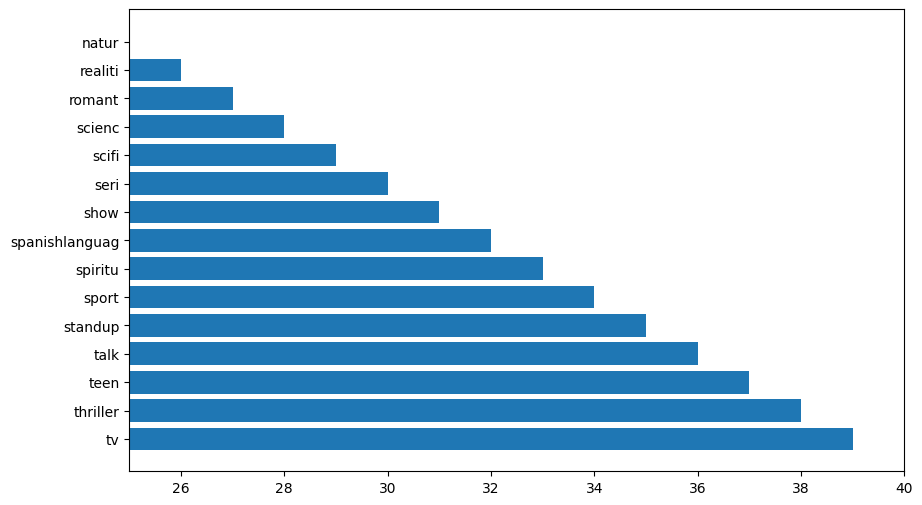

In [129]:
plt.figure( figsize = ( 10,6 ))
plt.xlim(25, 40 )
plt.barh(top15_most_ocurred_vocab_lised_in_after_stem_word , top15_most_occurred_words_listed_in_count )

Adding a new column length( listed-in ) which will contain length of listed_in

In [130]:
df['Length(listed-in)'] = df['listed_in'].apply(lambda x: len(x))
df.head(3)

,show_id,type,title,country,release_year,rating,duration,listed_in,description,relevant,Length(description),Length(listed-in)
0,s1,TV Show,3%,Brazil,2020,TV-MA,4 Seasons,intern tv show tv drama tv scifi fantasi,futur elit inhabit island paradis far crowd sl...,0,82,40
1,s2,Movie,7:19,Mexico,2016,TV-MA,93 min,drama intern movi,devast earthquak hit mexico citi trap survivor...,0,88,17
2,s3,Movie,23:59,Singapore,2011,R,78 min,horror movi intern movi,armi recruit found dead fellow soldier forc co...,0,102,23


In [131]:

df.columns
     

Index(['show_id', 'type', 'title', 'country', 'release_year', 'rating',
       'duration', 'listed_in', 'description', 'relevant',
       'Length(description)', 'Length(listed-in)'],
      dtype='object')

In [132]:
df[['description', 'Length(description)', 'listed_in' ,'Length(listed-in)' ]].head(3)

,description,Length(description),listed_in,Length(listed-in)
0,futur elit inhabit island paradis far crowd sl...,82,intern tv show tv drama tv scifi fantasi,40
1,devast earthquak hit mexico citi trap survivor...,88,drama intern movi,17
2,armi recruit found dead fellow soldier forc co...,102,horror movi intern movi,23


#Applying Different Clustering Algorithms

#Silhouette score

In [134]:
df.columns


Index(['show_id', 'type', 'title', 'country', 'release_year', 'rating',
       'duration', 'listed_in', 'description', 'relevant',
       'Length(description)', 'Length(listed-in)'],
      dtype='object')

In [138]:
no_of_category = []
for categories in df.listed_in.values:
  len_categories = len(categories.split(","))
  no_of_category.append(len_categories)
     

In [140]:
df['no_of_category'] = no_of_category

In [141]:
df[['listed_in' , 'no_of_category']].head()
     

,listed_in,no_of_category
0,intern tv show tv drama tv scifi fantasi,1
1,drama intern movi,1
2,horror movi intern movi,1
3,action adventur independ movi scifi fantasi,1
4,drama,1


In [142]:
df.no_of_category.unique()

array([1])

In [143]:
X_features_rec = df[['no_of_category' ,'Length(description)','Length(listed-in)']]
stdscaler = preprocessing.StandardScaler()

In [144]:
X_features_rec.describe()

,no_of_category,Length(description),Length(listed-in)
count,7787.0,7787.000000,7787.000000
mean,1.0,93.012200,24.327340
std,0.0,10.770412,10.690306
min,1.0,25.000000,4.000000
25%,1.0,87.000000,17.000000
50%,1.0,93.000000,24.000000
75%,1.0,100.000000,32.000000
max,1.0,185.000000,62.000000


In [145]:
X_rescale=stdscaler.fit_transform(X_features_rec)
X=X_rescale
silhouette_score_ = [  ]
range_n_clusters = [i for i in range(2,16)]

In [146]:
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(X)
    centers = clusterer.cluster_centers_

    score = silhouette_score(X, preds)
    silhouette_score_.append([int(n_clusters) , round(score , 3)])
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.3364382842862535
For n_clusters = 3, silhouette score is 0.34869822397262723
For n_clusters = 4, silhouette score is 0.3165929950835465
For n_clusters = 5, silhouette score is 0.30771661933259203
For n_clusters = 6, silhouette score is 0.3272779286509367
For n_clusters = 7, silhouette score is 0.3264534047331378
For n_clusters = 8, silhouette score is 0.32166471699860655
For n_clusters = 9, silhouette score is 0.31845859850830444
For n_clusters = 10, silhouette score is 0.3231445390565003
For n_clusters = 11, silhouette score is 0.32443348858896504
For n_clusters = 12, silhouette score is 0.324227255882401
For n_clusters = 13, silhouette score is 0.32914550326351627
For n_clusters = 14, silhouette score is 0.3264735646902664
For n_clusters = 15, silhouette score is 0.3270003318252033


In [147]:
temp = pd.DataFrame(silhouette_score_ , columns = ["n clusters" , "silhouette score"])
temp = temp.sort_values( "silhouette score" , ascending = False )
temp.head(14)

,n clusters,silhouette score
1,3,0.349
0,2,0.336
11,13,0.329
4,6,0.327
13,15,0.327
5,7,0.326
12,14,0.326
9,11,0.324
10,12,0.324
8,10,0.323


A score of 1 denotes the best meaning that the data point i is very compact within the cluster to which it belongs and far away from the other clusters. The worst value is -1. Values near 0 denote overlapping clusters

For n_clusters = 2 The average silhouette_score is : 0.3366488468454243
For n_clusters = 3 The average silhouette_score is : 0.34852265304536456
For n_clusters = 4 The average silhouette_score is : 0.31527646325925107
For n_clusters = 5 The average silhouette_score is : 0.3075330082845089
For n_clusters = 6 The average silhouette_score is : 0.3279336738842721
For n_clusters = 7 The average silhouette_score is : 0.33157672797360804
For n_clusters = 8 The average silhouette_score is : 0.32014881947120083
For n_clusters = 9 The average silhouette_score is : 0.32024701245232184
For n_clusters = 10 The average silhouette_score is : 0.32345435925823296
For n_clusters = 11 The average silhouette_score is : 0.32740999733999243
For n_clusters = 12 The average silhouette_score is : 0.3264091947639941
For n_clusters = 13 The average silhouette_score is : 0.3255075606927022
For n_clusters = 14 The average silhouette_score is : 0.32978196614538374
For n_clusters = 15 The average silhouette_score is

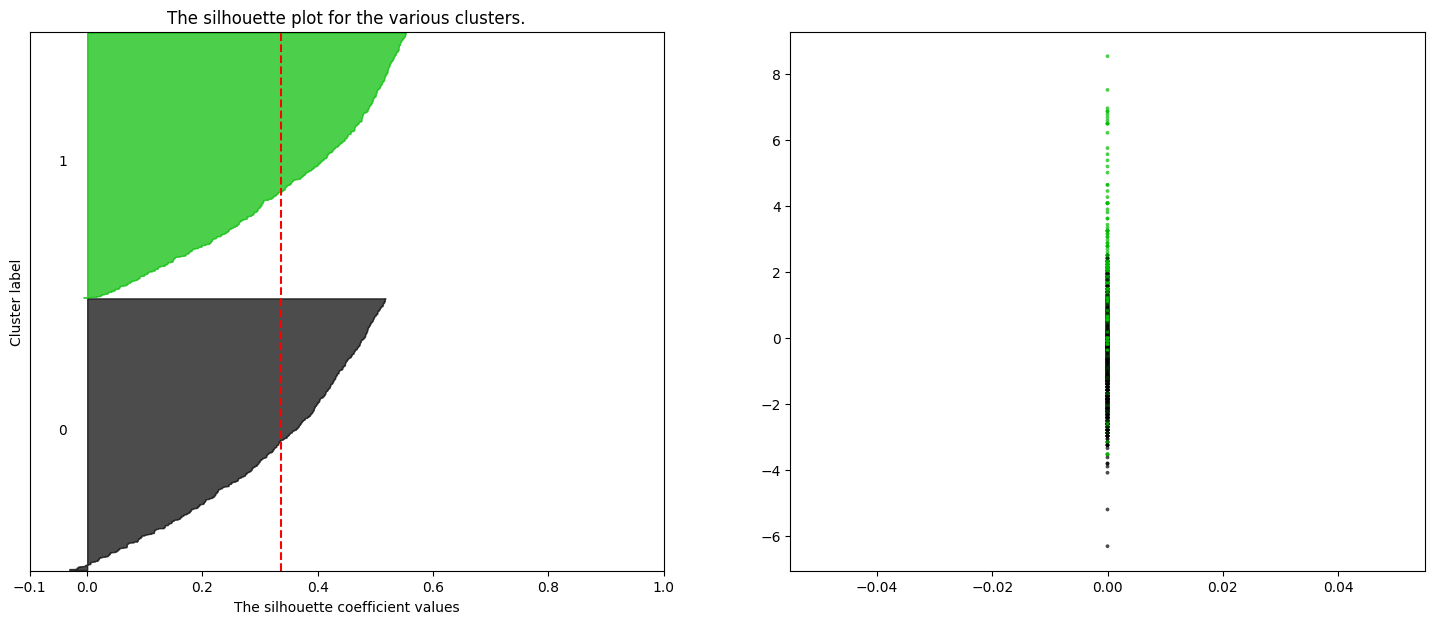

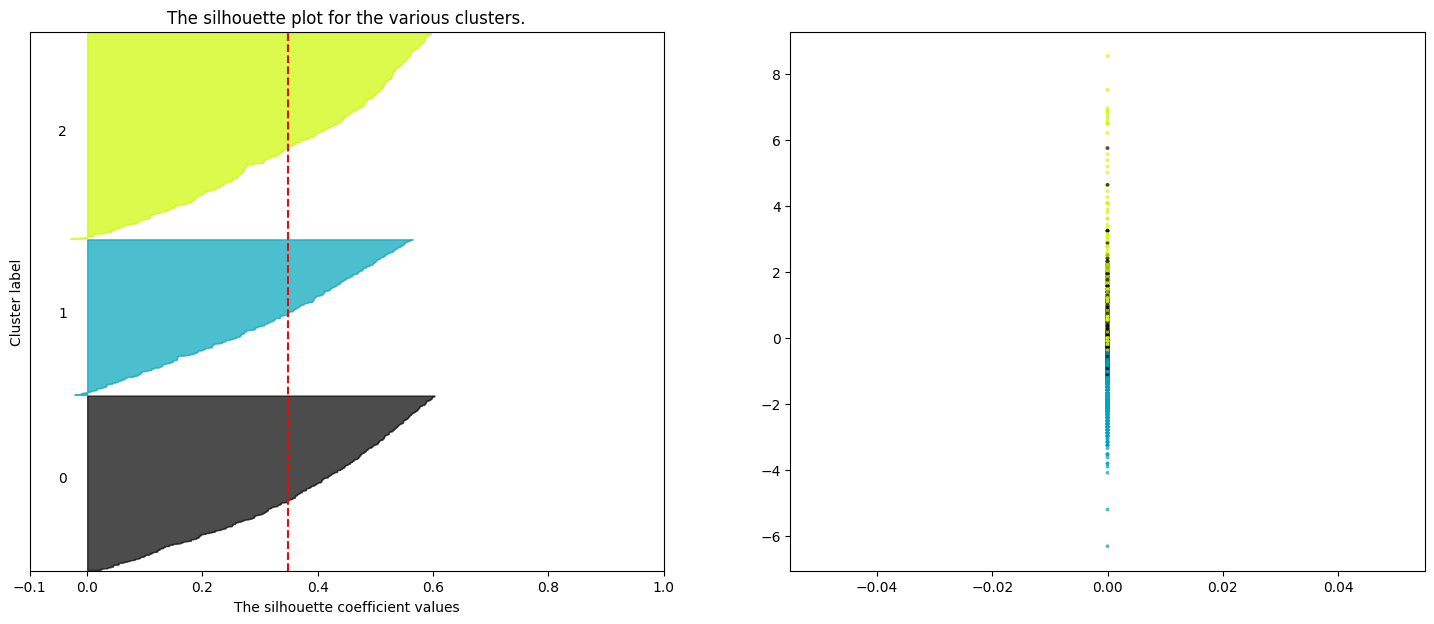

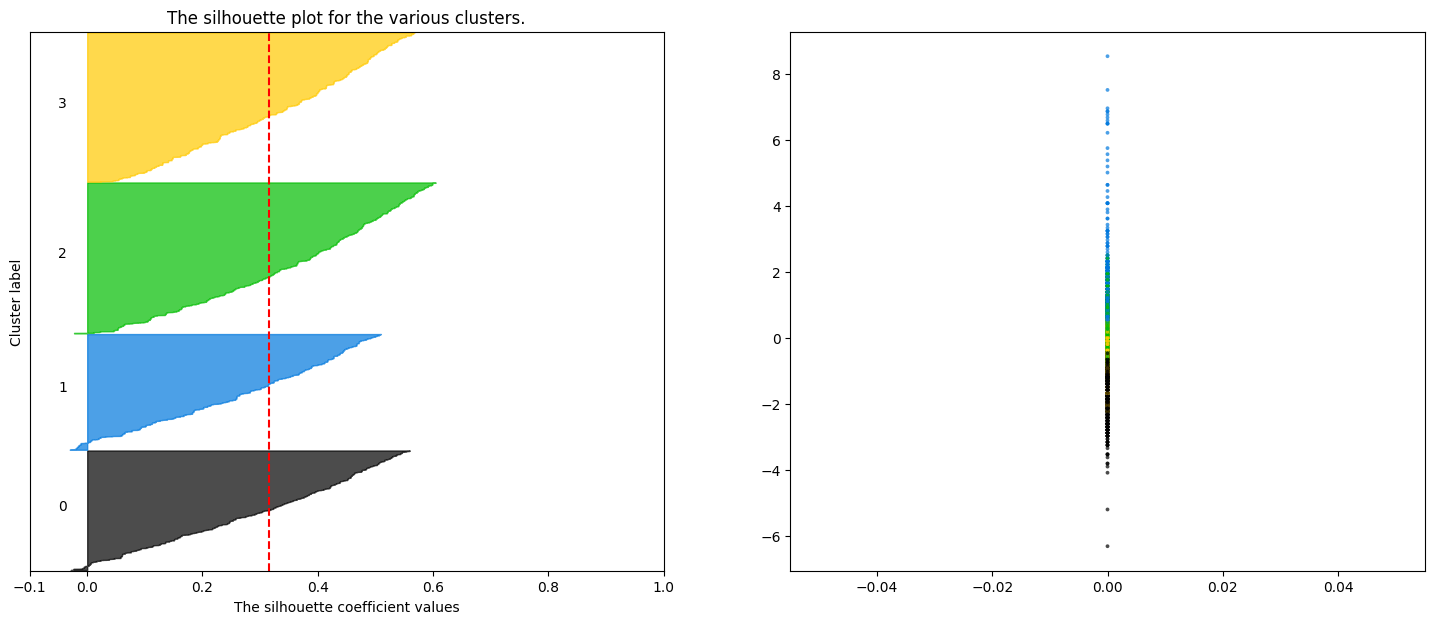

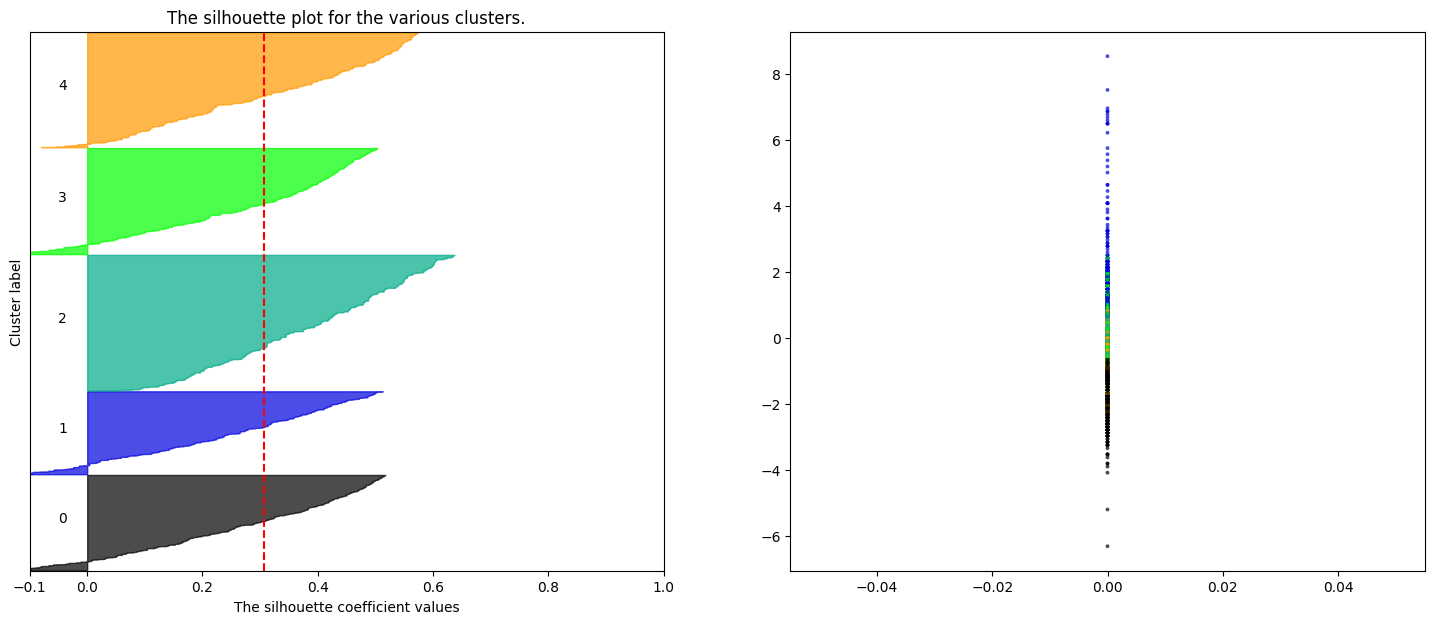

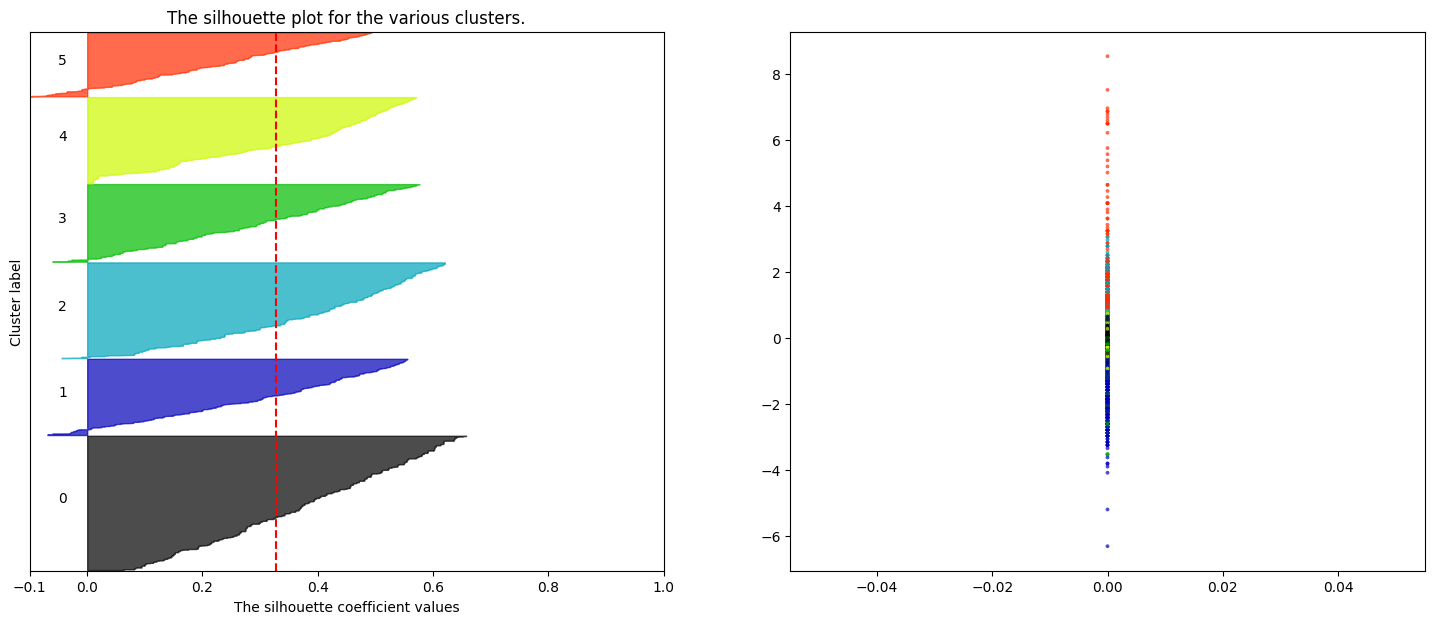

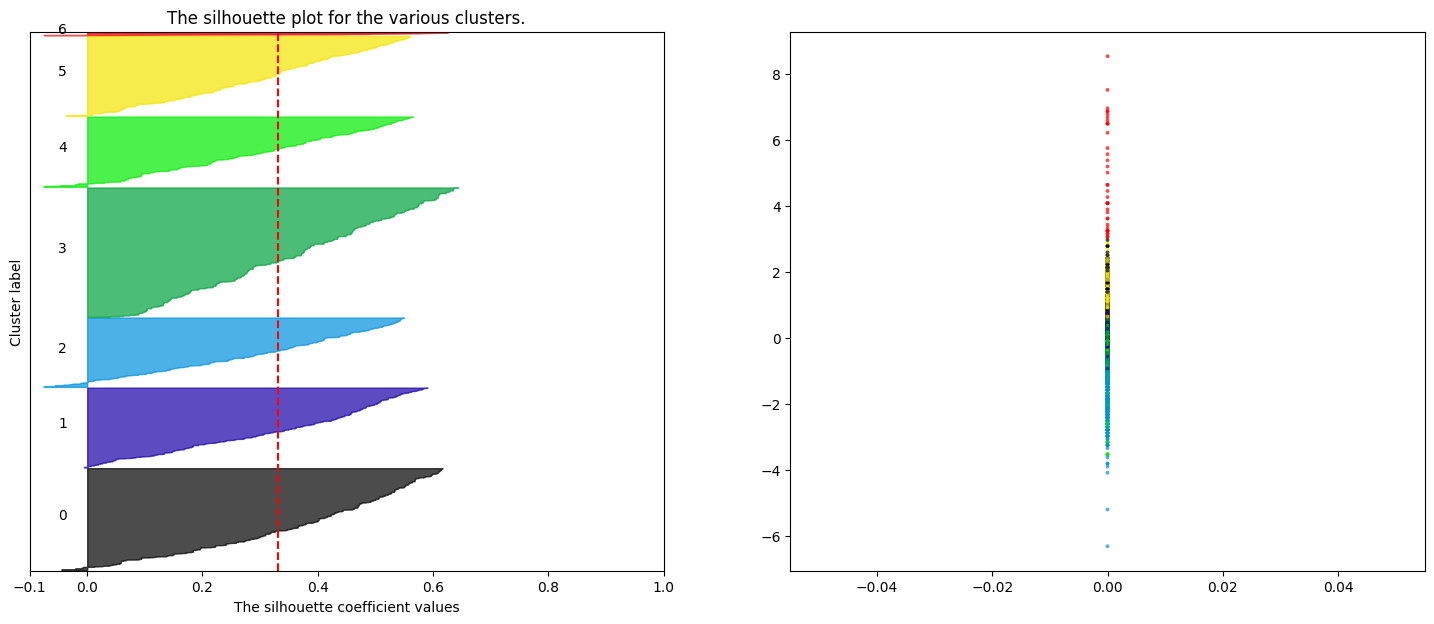

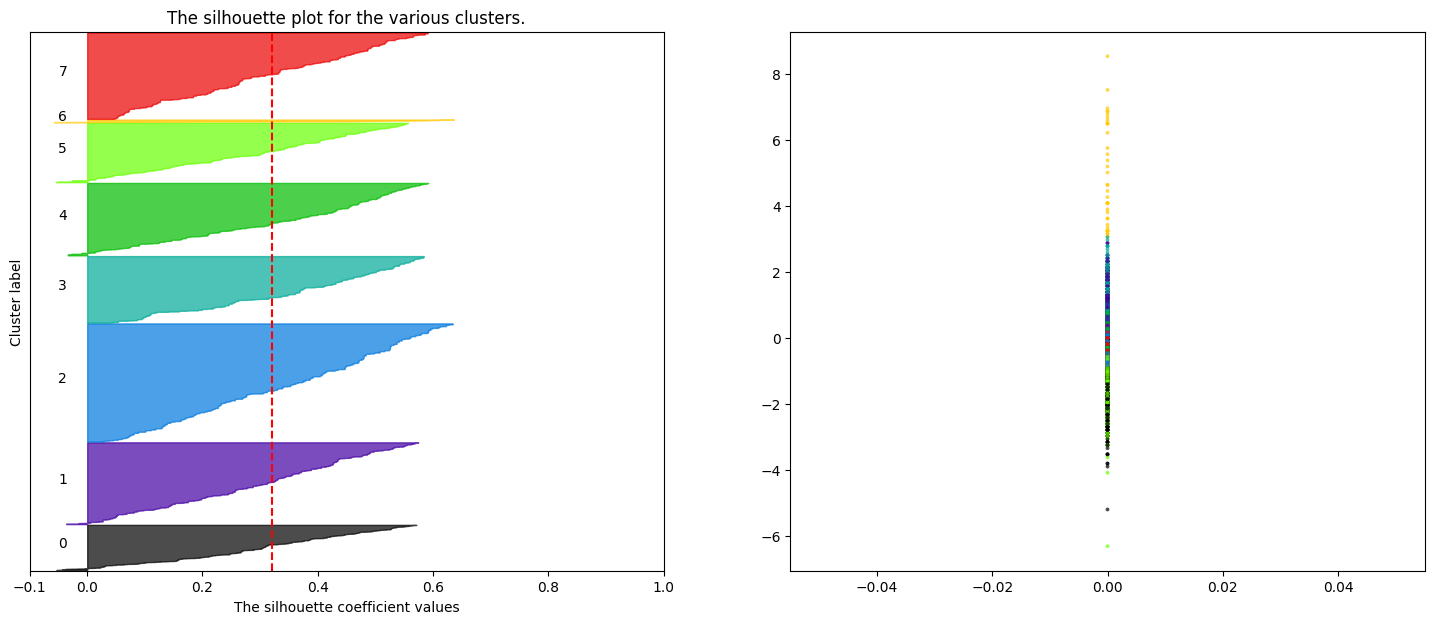

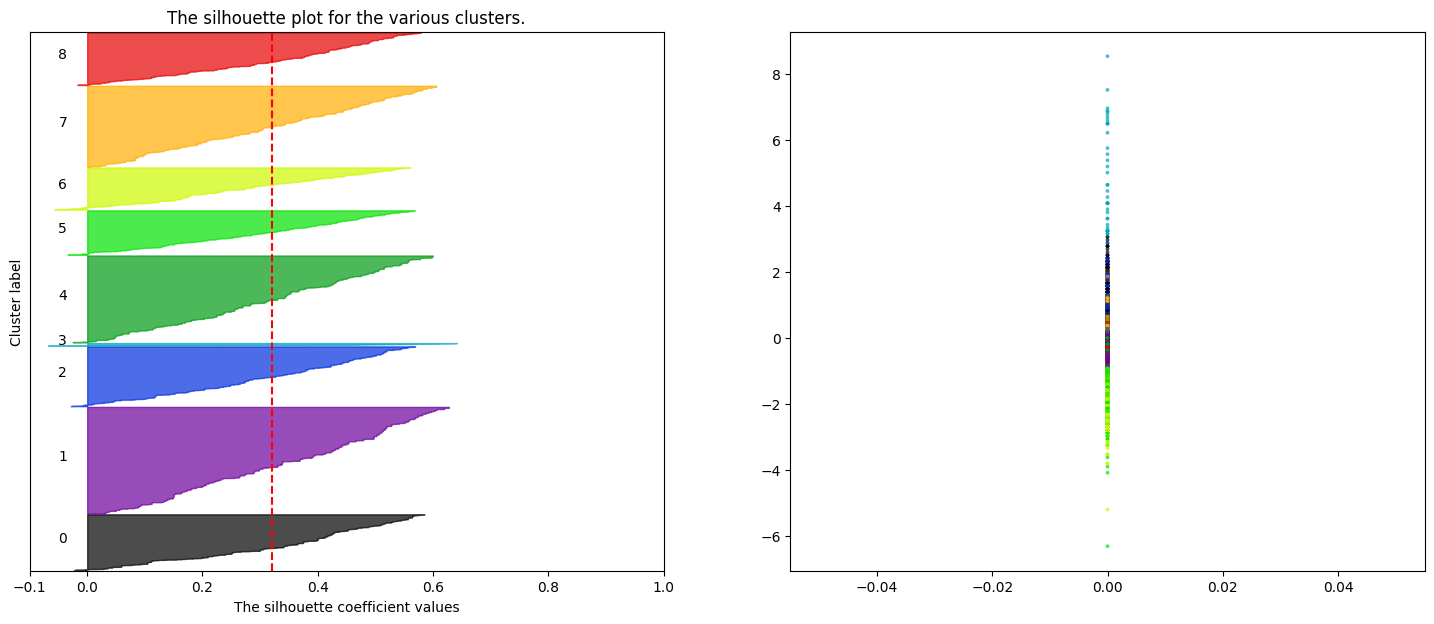

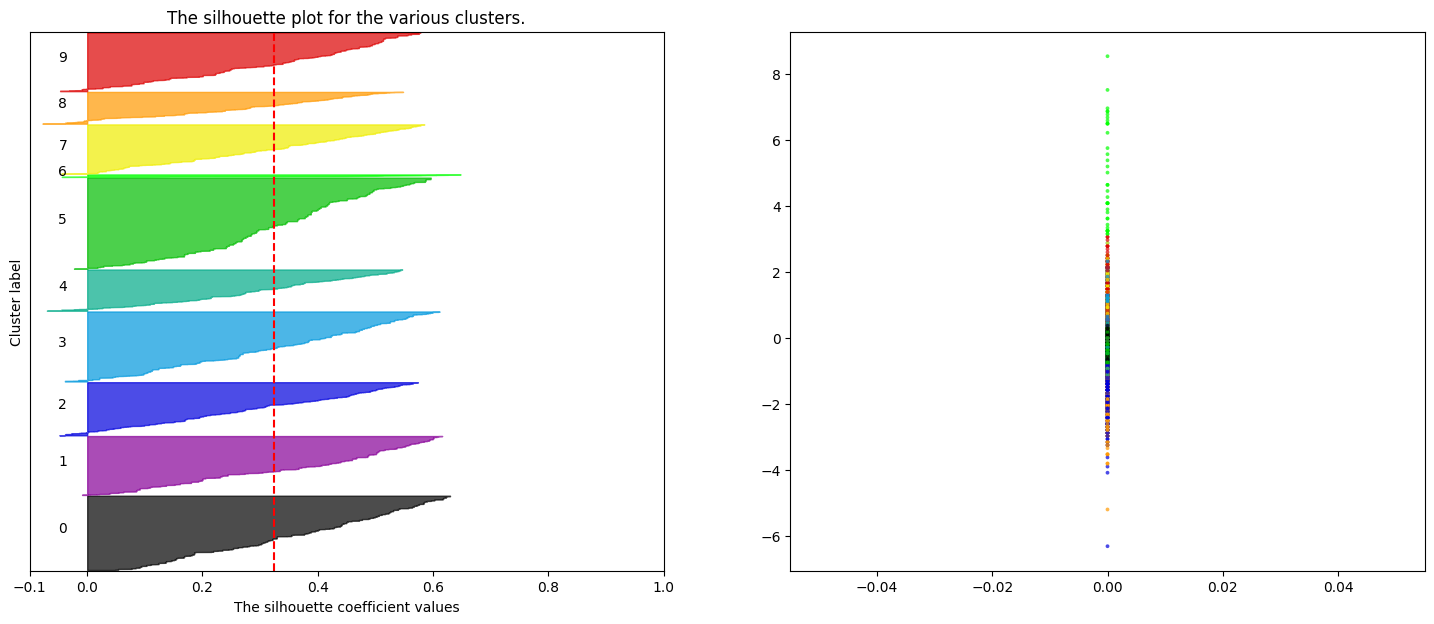

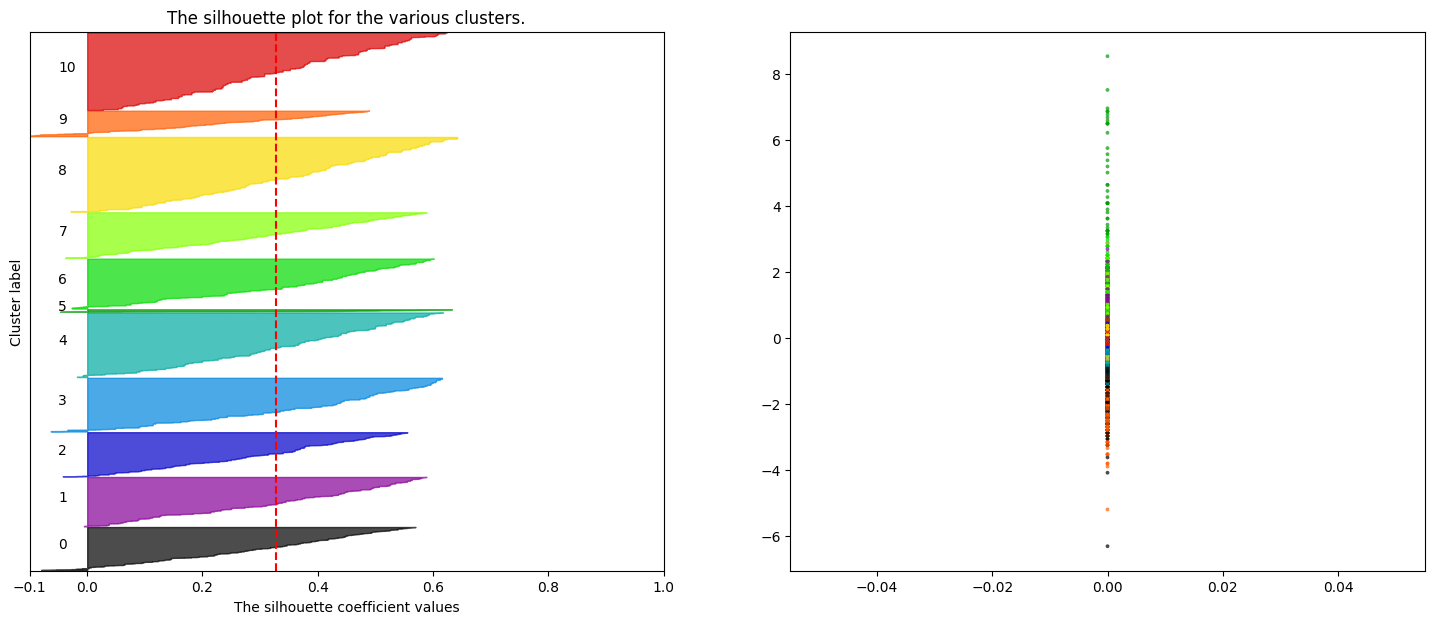

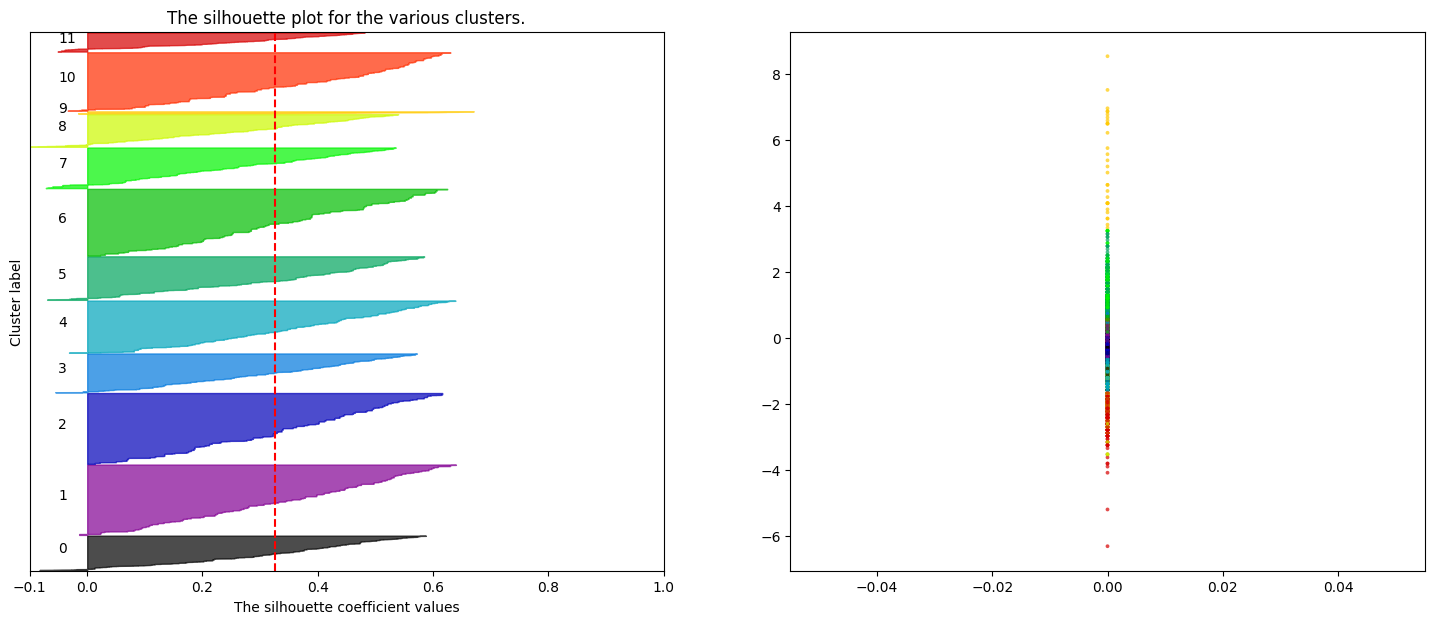

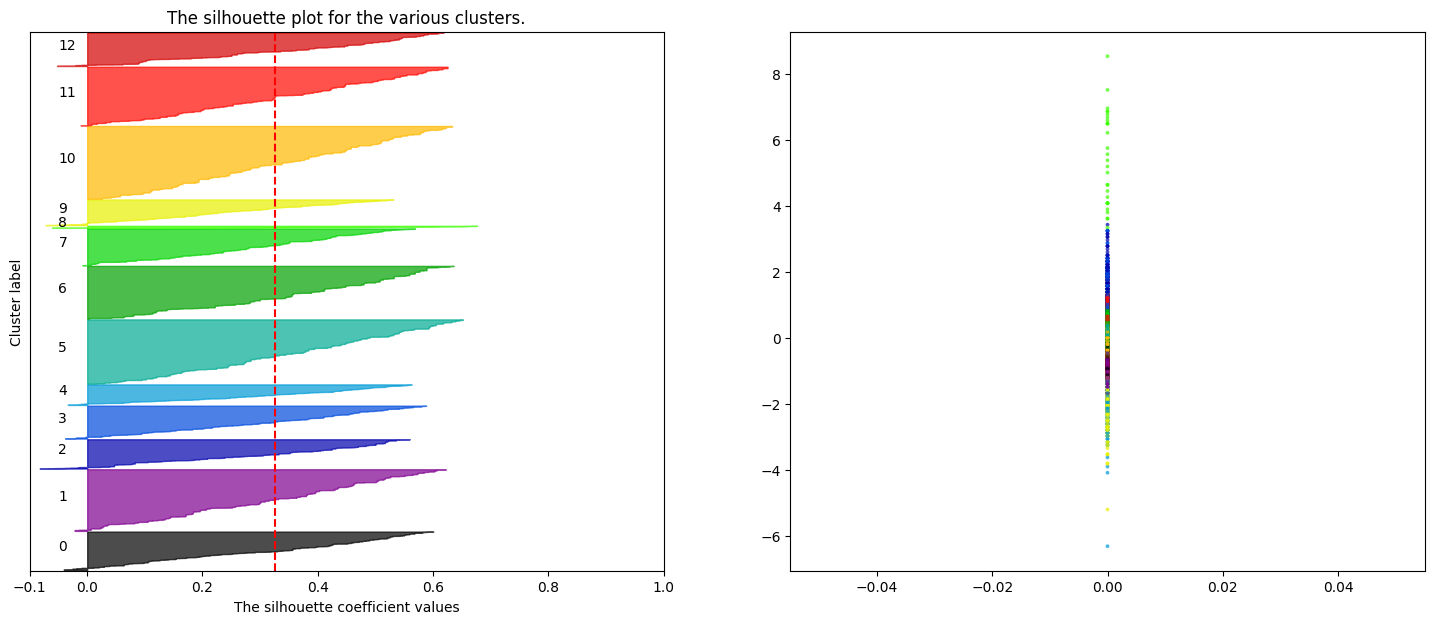

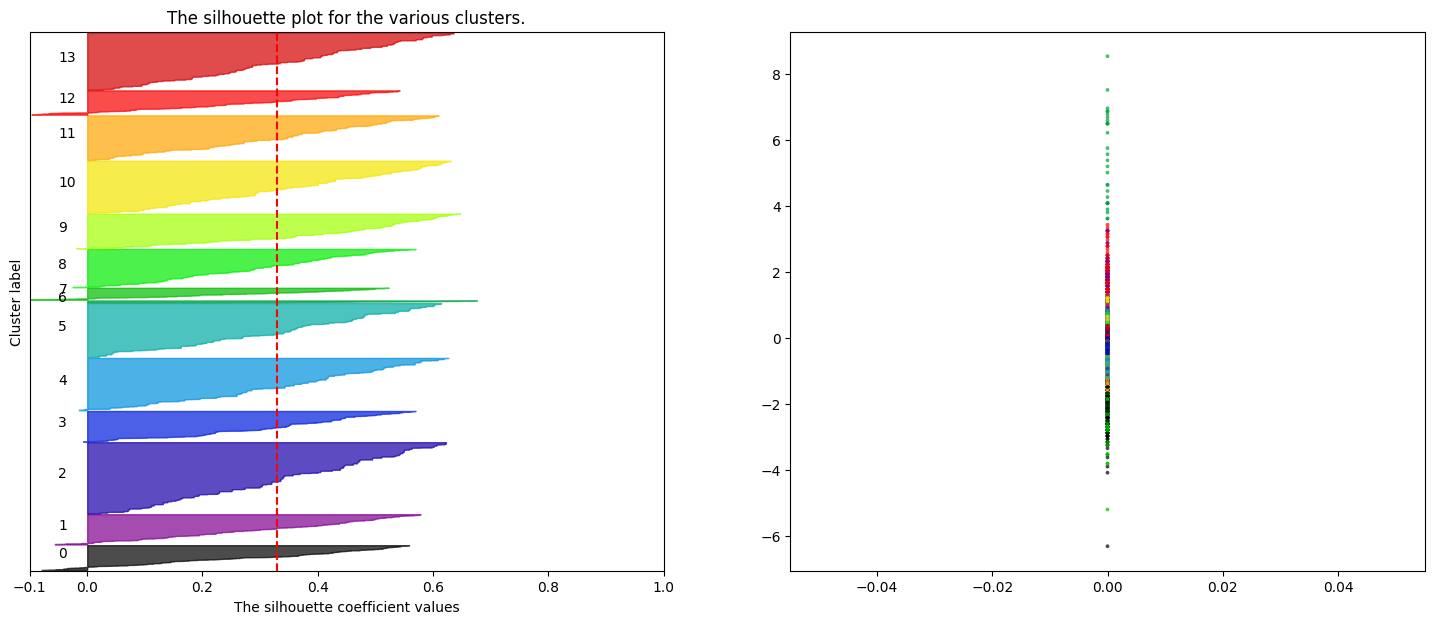

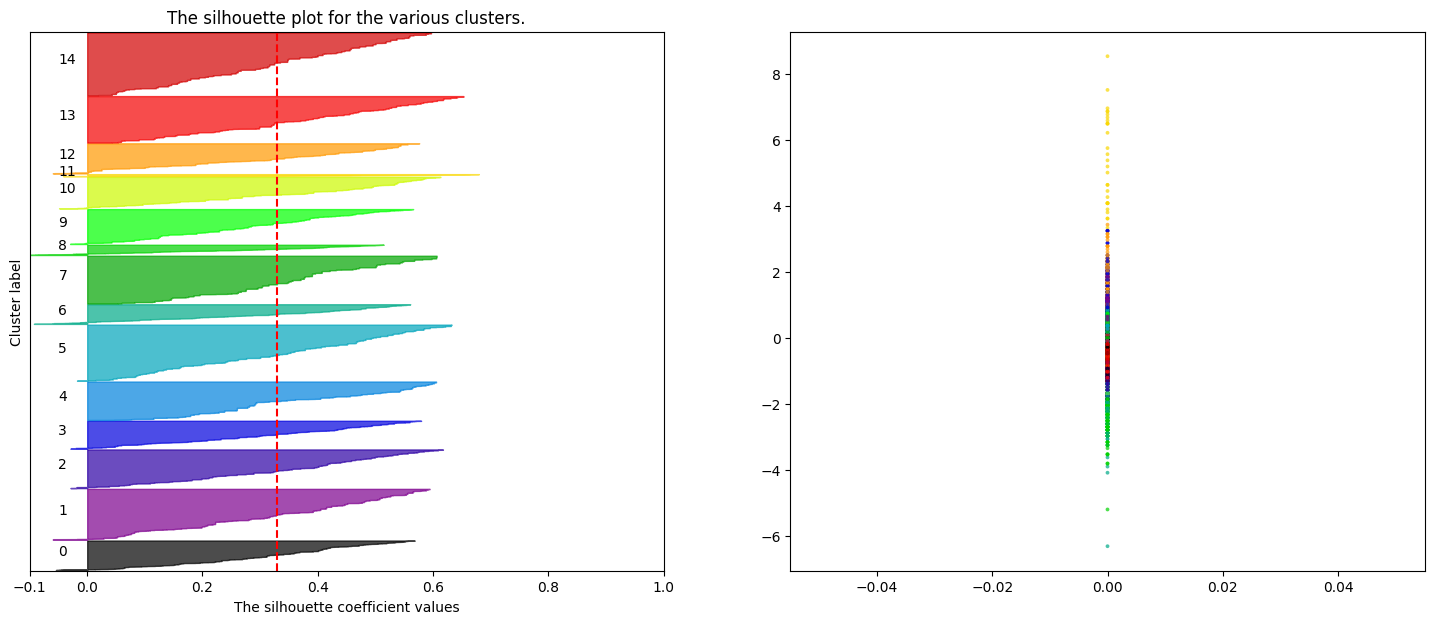

In [161]:
range_n_clusters = [i for i in range(2,16)]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) /n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
plt.show()

Silhouette score is used to evaluate the quality of clusters created using clustering algorithms such as K-Means in terms of how well samples are clustered with other samples that are similar to each other. The Silhouette score is calculated for each sample of different clusters. To calculate the Silhouette score for each observation/data point, the following distances need to be found out for each observations belonging to all the clusters:

Mean distance between the observation and all other data points in the same cluster. This distance can also be called a mean intra-cluster distance. The mean distance is denoted by a.

* Mean distance between the observation and all other data points of the next nearest cluster. This distance can also be called a mean nearest-cluster distance. The mean distance is denoted by b.

#Elbow Method

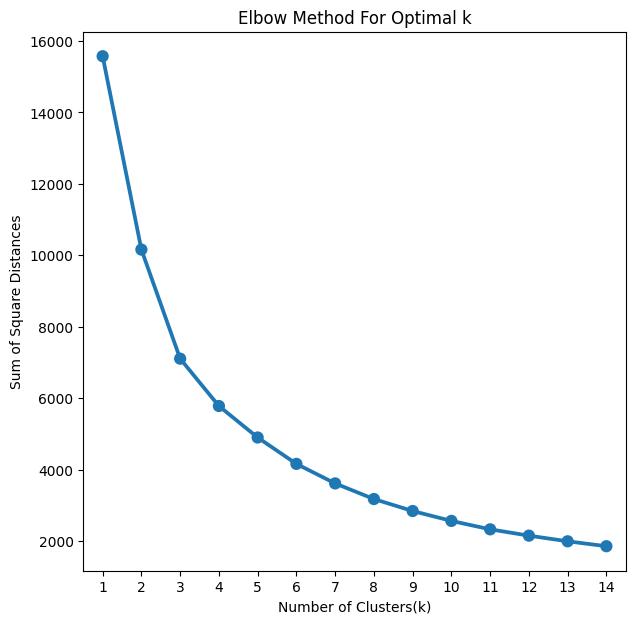

In [162]:
sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(X)
    sum_of_sq_dist[k] = km.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [163]:
kmeans = KMeans(n_clusters = 3 )
kmeans.fit(X)
y_kmeans= kmeans.predict(X)
     

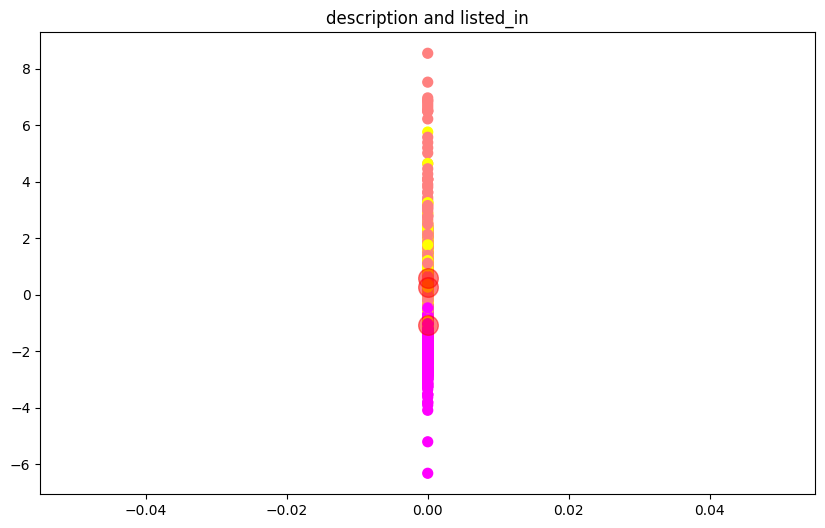

In [164]:
plt.figure(figsize=(10 , 6))
plt.title('description and listed_in')
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='spring')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)

#DBSCAN

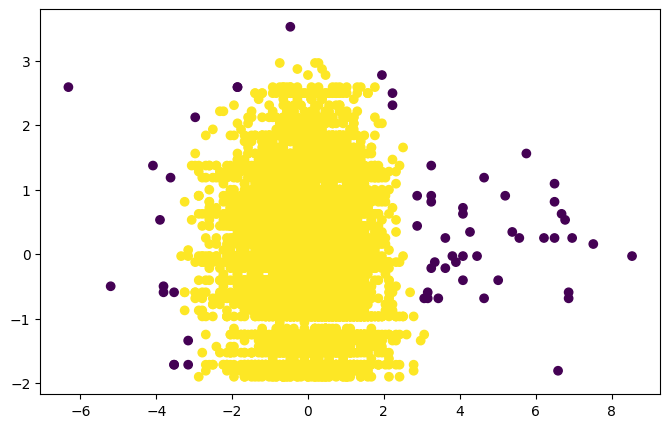

In [165]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
y_pred = DBSCAN(eps=0.5, min_samples=15).fit_predict(X)
plt.figure(figsize=( 8 , 5 ))
plt.scatter(X[:,1], X[:,2], c=y_pred)

#Dendrogram

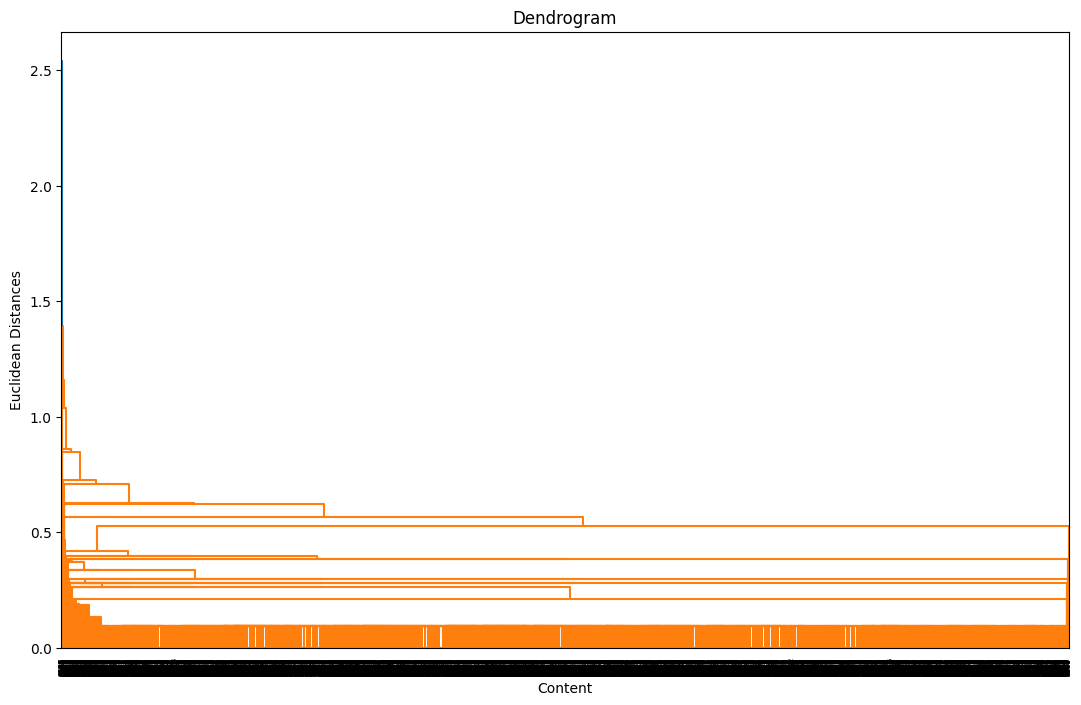

In [166]:
# Let's import sch
import scipy.cluster.hierarchy as sch
plt.figure(figsize=(13,8))
dendrogram = sch.dendrogram(sch.linkage(X, method = 'single'))
plt.title('Dendrogram')
plt.xlabel('Content')
plt.ylabel('Euclidean Distances')
plt.show() # find largest vertical distance we can make without crossing any other horizontal line
     

#AgglomerativeClustering

In [167]:
# Let's  import AgglomerativeClustering
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X)
     

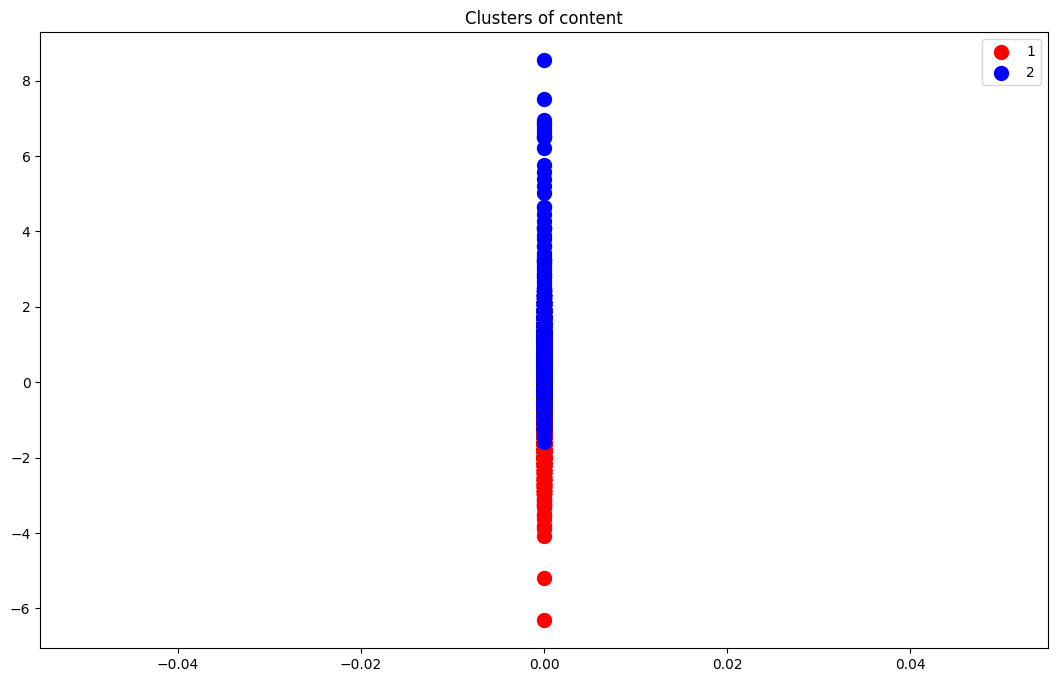

In [168]:
# Visualizing the clusters (three dimensions only)
plt.figure(figsize=(13,8))
plt.scatter(X[y_hc == 0, 0], X[y_hc == 0, 1], s = 100, c = 'red', label = '1')
plt.scatter(X[y_hc == 1, 0], X[y_hc == 1, 1], s = 100, c = 'blue', label = '2')
# plt.scatter(X[y_hc == 2, 0], X[y_hc == 2, 1], s = 100, c = 'green', label = '3')

plt.title('Clusters of content')

plt.legend()
plt.show()